In [1]:
import os
import time
import math
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import train_test_split
from accelerate import Accelerator, notebook_launcher
from transformers import BertTokenizer, BertModel, BertConfig, BertForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [4]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_sample_data = manager.list()
new_sample_labels = manager.list()

# Non shared resources
epochs = 10
batch_size = 32
sequence_length = 96

# LOAD AND PREPROCESS DATA

In [5]:
train_data = pd.read_csv('/kaggle/input/netifier/processed_train.csv', encoding='latin-1')
val_data = pd.read_csv('/kaggle/input/netifier/processed_test.csv', encoding='latin-1')

data = pd.concat([train_data, val_data], ignore_index=True)
data.shape

(7773, 7)

In [6]:
data.head()

,original_text,source,pornografi,sara,radikalisme,pencemaran_nama_baik,processed_text
0,[QUOTE=jessepinkman16;5a50ac34d89b093f368b456e...,kaskus,0,0,0,1,jabar memang provinsi barokah boleh juga dan n...
1,"@verosvante kita2 aja nitizen yang pada kepo,t...",instagram,0,0,0,0,kita saja nitizen yang pada penasaran toh kelu...
2,"""#SidangAhok smg sipenista agama n ateknya mat...",twitter,0,1,1,1,sidangahok semoga sipenista agama dan ateknya ...
3,@bolususulembang.jkt barusan baca undang2 ini....,instagram,0,0,0,0,jakarta barusan baca undang ini tetap dibedaka...
4,bikin anak mulu lu nof \nkaga mikir apa kasian...,kaskus,0,0,0,0,buat anak melulu kamu nof nkaga mikir apa kasi...


In [7]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

train_labels = train_data.columns[2:6]
test_labels = test_data.columns[2:6]

# Extract features and labels for training and validation
X_train = train_data['processed_text'].values
y_train = train_data[train_labels].values
X_test = test_data['processed_text'].values
y_test = test_data[test_labels].values

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6218,) (6218, 4)
(1555,) (1555, 4)


# BULDING DATASET

In [8]:
class ClfDataset(Dataset):
    def __init__(self, data, labels, tokenizer, label2id):
        # Initialize dataset with data, tokenizer, and label mappings
        self.data = data
        self.tokenizer = tokenizer
        self.label2id = label2id
        self.maxlength = sequence_length  # Maximum token length for input sequences
        self.all_labels_num = len(label2id)  # Total number of labels
        self.pair_wise_sampled = None  # Tracks sampling status of label pairs
        self.gt_labels = labels  # Ground truth labels in one-hot format
        self.all_labeled_mask = None  # Indicates whether all labels of a sample have been queried
        self.init()  # Initializes sampling and label mask states

    def init(self):
        # Initialize sampled pairs and mask for all data
        self.pair_wise_sampled = torch.ones(len(self.data), self.all_labels_num)
        self.all_labeled_mask = torch.zeros(len(self.data))  # Initially, no data is fully labeled

    def get_label_Cardinality(self):
        # Compute label cardinality, representing average positive labels per sample in the labeled pool
        labed_cnt = torch.sum(self.all_labeled_mask)  # Total number of samples fully labeled
        all_labed_pos_label_cnt = torch.sum(self.all_labeled_mask.unsqueeze(-1) * self.gt_labels)
        return all_labed_pos_label_cnt / labed_cnt  # Average number of positive labels per fully labeled sample

    def update_data(self, query_example_indices, query_label_indices=None, init_time=False):
        # Update dataset with new labeled data points and labels after each query cycle
        if query_label_indices is not None:
            ones = torch.ones(self.all_labels_num)
            for example_idx, label_idx in zip(query_example_indices, query_label_indices):
                # Access individual data and update based on queried label
                one_data = self.__getitem__(example_idx)
                one_label = one_data[1][label_idx]
                if one_label == 0:
                    # Set pair-wise sampled state for newly queried labels
                    self.pair_wise_sampled[example_idx][label_idx] = 1
                else:
                    self.pair_wise_sampled[example_idx][label_idx] = 1
                
                # Update all_labeled_mask if all labels for a sample are queried
                if torch.sum(ones - self.pair_wise_sampled[example_idx]) == 0:
                    self.all_labeled_mask[example_idx] = 1
        else:
            # Mark all labels as queried for each example if only examples are specified
            for example_idx in query_example_indices:
                ones = torch.ones(self.all_labels_num)
                self.pair_wise_sampled[example_idx] = ones
                self.all_labeled_mask[example_idx] = 1

    def get_labeled_set(self):
        # Return list of indices for samples that have been fully labeled
        labeled_set = []
        for idx, mask in enumerate(self.all_labeled_mask):
            if mask != 0:
                labeled_set.append(idx)
        return labeled_set

    def __len__(self):
        # Return the number of samples in the dataset
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx] 
        labels = self.gt_labels[idx]

        # Tokenize the raw text and apply padding/truncation to reach maxlength
        encoding = self.tokenizer(
            item,
            padding='max_length',
            truncation=True,
            max_length=self.maxlength,
            return_tensors="pt"
        )

        # Extract tokenized fields
        input_ids = encoding['input_ids'].squeeze(0)  # Remove batch dimension
        input_type_ids = encoding.get('token_type_ids', torch.zeros_like(input_ids))
        input_mask = encoding['attention_mask'].squeeze(0)

        text_inputs = [input_ids, input_type_ids, input_mask]
        sampler_loss_weight = self.pair_wise_sampled[idx]  # Weight for active learning sample selection

        # Return inputs for model: tokenized text, labels, sample index, sampling weights, labeling status
        inputs_list = [text_inputs, labels, idx, sampler_loss_weight, self.all_labeled_mask[idx]]
        return inputs_list

In [9]:
def load_data(label2id):
    tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
    
    train_dataset = ClfDataset(
        data=train_data['processed_text'].values,
        labels=train_data[train_data.columns[2:6]].values,
        tokenizer=tokenizer,
        label2id=label2id,
    )
    test_dataset = ClfDataset(
        data=test_data['processed_text'].values,
        labels=test_data[test_data.columns[2:6]].values,
        tokenizer=tokenizer,
        label2id=label2id,
    )
    
    return train_dataset, test_dataset, len(train_data), len(test_data)

def load_label():
    label_freq_desc = [['pornografi', 1574], ['sara', 1124], ['radikalisme', 1154], ['pencemaran_nama_baik', 2180]]
    label_weight = [x[1] for x in label_freq_desc]
    label_index = [x[0] for x in label_freq_desc]
    labels = label_index
    label2id = {j: i for i, j in enumerate(labels)}
    print('label num', len(labels))
    return len(labels), label2id

def label2list(label):
    print(label)
    outputs = [[] for _ in range(label.shape[0])]
    x,y = np.where(label==1)
    for xx,yy in zip(x,y):
        outputs[xx].append(yy)
    return outputs

# DEFINE THE MODEL

In [10]:
class IndoBERT_Backbone(nn.Module):
    def __init__(self, label_num):
        super(IndoBERT_Backbone, self).__init__()
        self.label_num = label_num
        self.encoder = IndoBERT_Encoder(label_num)
        model_config = BertConfig.from_pretrained("indobenchmark/indobert-base-p1")
        self.clf = nn.Linear(model_config.hidden_size, label_num)
        nn.init.xavier_uniform_(self.clf.weight)

    def forward(self, inputs):
        encoder_out = self.encoder(inputs)
        out = self.clf(encoder_out)
        return out, encoder_out

class IndoBERT_Encoder(nn.Module):
    def __init__(self, label_num):
        super(IndoBERT_Encoder, self).__init__()
        self.label_num = label_num
        self.encoder = BertModel.from_pretrained(
            'indobenchmark/indobert-base-p1',
            num_labels=self.label_num,
        )
        
        self.encoder_init()

    def encoder_init(self):
        all_layers = ['embeddings', 'layer.0', 'layer.1', 'layer.2', 'layer.3', 'layer.4', 'layer.5', 'layer.6',
                      'layer.7', 'layer.8', 'layer.9', 'layer.10', 'layer.11', 'pooler']
        unfreeze_layers = all_layers[7:]
        for name, param in self.encoder.named_parameters():
            param.requires_grad = False
            for ele in unfreeze_layers:
                if ele in name:
                    param.requires_grad = True
                    break

    def forward(self, inputs):
        # Ensure each component in inputs is a tensor
        input_ids = torch.tensor(inputs[0]) if not isinstance(inputs[0], torch.Tensor) else inputs[0]
        token_type_ids = torch.tensor(inputs[1]) if not isinstance(inputs[1], torch.Tensor) else inputs[1]
        attention_mask = torch.tensor(inputs[2]) if not isinstance(inputs[2], torch.Tensor) else inputs[2]
        
        input_ids = input_ids.view(-1, input_ids.size(-1))  # Ensuring batch_size, sequence_length
        token_type_ids = token_type_ids.view(input_ids.size(0), -1)  # Reshaping to [batch_size, sequence_length]
        attention_mask = attention_mask.view(-1, attention_mask.size(-1))
        
        outputs = self.encoder(
            input_ids=input_ids,
            token_type_ids=token_type_ids,
            attention_mask=attention_mask,
        )
        cls_output = outputs.pooler_output
        return cls_output

In [11]:
class MLP_VAE(nn.Module):
    def __init__(self, hidden_size, device):
        super(MLP_VAE, self).__init__()
        self.device = device
        self.label_num = 4
        self.cl_neg_mode = 1
        self.proto_size = 128
        self.hidden_size = hidden_size
        
        # Initial fully connected layer to project input to higher-dimensional space for each label
        self.fc0 = nn.Linear(self.hidden_size, self.label_num * 512)
        self.fc1 = nn.Linear(512, self.proto_size)  # Dimensionality reduction for prototypes

        # Adjust the number of label representations based on contrastive learning mode
        if self.cl_neg_mode == 0:
            cl_label_num = self.label_num  # Standard label number
        elif self.cl_neg_mode == 1:
            cl_label_num = self.label_num + 1  # Add one for negative prototype handling
            self.ins_neg_cnt = torch.zeros(1).to(device)
        elif self.cl_neg_mode == 2:
            cl_label_num = self.label_num * 2  # Double for positive and negative prototypes
            self.ins_neg_cnt = torch.zeros(self.label_num).to(device)
        self.cl_label_num = cl_label_num

        # Register buffer for label prototypes, aligned with CoMAL's prototype-based sampling
        self.register_buffer("prototypes", torch.zeros(self.cl_label_num, self.proto_size))
        self.ins_pos_cnt = torch.zeros(self.label_num).to(device)  # Track count of positive instances

        # Decoder and final aggregation layers
        self.fc3 = nn.Linear(self.proto_size, 512)
        self.agg = nn.Linear(self.label_num * 512, self.hidden_size)
        self.clf = nn.Linear(self.hidden_size, self.label_num)  # Classification layer

    def get_protos(self):
        return self.prototypes  # Return the prototypes for external use

    def reparameterize(self, mu, logvar):
        # VAE reparameterization trick for latent space sampling
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def reset_proto(self):
        # Reset prototype and count buffers
        self.ins_pos_cnt *= 0
        self.ins_neg_cnt *= 0
        self.prototypes *= 0

    def forward(self, x, labels=None, weights=None):
        # Project input into sub-representations per label
        sub_rep_ori = self.fc0(x)
        sr_shape = sub_rep_ori.shape
        sub_rep_ori = sub_rep_ori.view(sr_shape[0], self.label_num, -1)  # Split per label

        # Further reduction to prototype size and decoding step
        sub_rep = self.fc1(sub_rep_ori)
        dec_sub_rep = self.fc3(sub_rep)

        dist_1 = None
        sub_rep_norm = F.normalize(sub_rep.data, dim=-1)  # Normalize for distance calculations

        if labels is not None and weights is not None:
            # Generate masks for positive and negative samples
            pos_mask = labels * weights
            neg_mask = (1 - labels) * weights
            pos_mask = pos_mask.unsqueeze(-1)
            neg_mask = neg_mask.unsqueeze(-1)

            # Update prototypes based on positive and negative samples
            feat = torch.sum(sub_rep_norm * pos_mask, dim=0)
            self.prototypes[:self.label_num] = self.prototypes[:self.label_num] * self.ins_pos_cnt.unsqueeze(-1) + feat

            # Handle different contrastive learning modes
            if self.cl_neg_mode == 2:
                feat_neg = torch.sum(sub_rep_norm * neg_mask, dim=0)
                self.prototypes[self.label_num:] = self.prototypes[self.label_num:] * self.ins_neg_cnt.unsqueeze(-1) + feat_neg
                self.ins_neg_cnt += torch.sum(neg_mask.squeeze(-1), dim=0)
            elif self.cl_neg_mode == 1:
                feat_neg = torch.sum(sub_rep_norm * neg_mask, dim=0)
                feat_neg = torch.sum(feat_neg, dim=0)
                self.prototypes[-1] = self.prototypes[-1] * self.ins_neg_cnt + feat_neg
                self.ins_neg_cnt += torch.sum(neg_mask)
            
            # Update positive instance counts and normalize prototypes
            self.ins_pos_cnt += torch.sum(pos_mask.squeeze(-1), dim=0)
            self.prototypes = F.normalize(self.prototypes, p=2, dim=-1)

        # Calculate distances between sub-representations and prototypes
        if self.cl_neg_mode == 2:
            dist_1 = torch.einsum('bld,ld->bl', [sub_rep_norm, self.prototypes[:self.label_num]])
            dist_neg_1 = torch.einsum('bld,ld->bl', [sub_rep_norm, self.prototypes[self.label_num:]])
            dist_1 = torch.cat([dist_1, dist_neg_1], dim=1)  # Combine distances for positive and negative prototypes
        elif self.cl_neg_mode == 0 or self.cl_neg_mode == 1:
            dist_1 = sub_rep_norm @ self.prototypes.T  # Standard matrix multiplication for distance calculation

        # Decode and classify reconstructed input
        concat_sub_rep = dec_sub_rep.contiguous().view(dec_sub_rep.shape[0], -1)
        recon_x = self.agg(concat_sub_rep)
        recon_x_clf = self.clf(recon_x)

        return recon_x, sub_rep, recon_x_clf, dist_1  # Return reconstruction, sub-representation, classification, and distances

In [12]:
def get_cl_labels(labels, label_num, weight, cl_neg_mode=1):
    cl_labels = torch.zeros_like(labels, dtype=torch.long)
    cl_labels.fill_(label_num)
    example_idx, label_idx = torch.where(labels>=0.5)
    cl_labels[example_idx, label_idx] = label_idx #.float()
    cl_labels = cl_labels * weight + label_num * (1 - weight)
    if cl_neg_mode == 2:
        example_idx, label_idx = torch.where(labels < 0.5)
        cl_neg_labels = label_idx + label_num
        cl_labels[example_idx, label_idx] = cl_neg_labels.float()
        cl_labels = cl_labels * weight + 2 * label_num * (1 - weight)
    cl_labels = cl_labels.to(torch.int)
    return cl_labels

def get_cl_mask(cl_labels, label_num, batch_size, cl_neg_mode=1):
    mask = torch.eq(cl_labels[:batch_size], cl_labels.T).float()
    if cl_neg_mode == 0:
        neg_idx, _ = torch.where(cl_labels[:batch_size] >= label_num)
        neg_mask = torch.ones_like(mask)
        neg_mask[neg_idx] = 0
        neg_mask[:, neg_idx] = 0
        mask *= neg_mask
    elif cl_neg_mode == 1:
        neg_idx, _ = torch.where(cl_labels[:batch_size] > label_num)
        neg_mask = torch.ones_like(mask)
        neg_mask[neg_idx] = 0
        neg_mask[:, neg_idx] = 0
        mask *= neg_mask
    elif cl_neg_mode == 2:
        neg_idx, _ = torch.where(cl_labels[:batch_size] >= label_num * 2)
        neg_mask = torch.ones_like(mask)
        neg_mask[neg_idx] = 0
        neg_mask[:, neg_idx] = 0
        mask *= neg_mask
    else:
        neg_mask = torch.ones_like(mask)
    return mask, neg_mask

# DEFINE LOSSES

In [13]:
class SupConLoss(nn.Module):
    """Following Supervised Contrastive Learning:
        https://arxiv.org/pdf/2004.11362.pdf."""

    def __init__(self, temperature=0.07, base_temperature=0.07):
        super().__init__()
        self.temperature = temperature
        self.base_temperature = base_temperature

    def forward(self, features, mask, neg_mask=None, batch_size=-1, device=None, other_features=None):
        if mask is not None:
            # SupCon loss (Partial Label Mode)
            mask = mask.float().detach()
            # compute logits
            if other_features is None:
                anchor_dot_contrast = torch.div(
                    torch.matmul(features[:batch_size], features.T),
                    self.temperature)
            else:
                anchor_dot_contrast = torch.div(
                    torch.matmul(features[:batch_size], other_features.T),
                    self.temperature)

            # for numerical stability
            logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
            logits = anchor_dot_contrast - logits_max.detach()

            # mask-out self-contrast cases
            if neg_mask is None:
                logits_mask = torch.ones_like(mask)
            else:
                logits_mask = torch.scatter(
                    neg_mask,
                    1,
                    torch.arange(batch_size).view(-1, 1).to(device),
                    0
                )
            mask = mask * logits_mask

            # compute log_prob
            exp_logits = torch.exp(logits) * logits_mask
            log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True) + 1e-12)
            # compute mean of log-likelihood over positive
            mean_log_prob_pos = (mask * log_prob).sum(1) / (mask.sum(1) + 1e-12)
            # loss
            loss = - (self.temperature / self.base_temperature) * mean_log_prob_pos
            loss = loss.mean()
        else:
            q = features[:batch_size]
            k = features[batch_size:batch_size * 2]
            queue = features[batch_size * 2:]
            l_pos = torch.einsum('nc,nc->n', [q, k]).unsqueeze(-1)
            # negative logits: NxK
            l_neg = torch.einsum('nc,kc->nk', [q, queue])
            # logits: Nx(1+K)
            logits = torch.cat([l_pos, l_neg], dim=1)

            # apply temperature
            logits /= self.temperature

            # labels: positive key indicators
            labels = torch.zeros(logits.shape[0], dtype=torch.long).cuda()
            loss = F.cross_entropy(logits, labels)

        return loss

# MODEL TRAINING AND TESTING

In [14]:
total_data = len(train_data) + len(test_data)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 200

In [15]:
def train_total_sep2(dataloaders, trials, metrics, current_train_size, filename, label_num=-1, total_patience=3):
    accelerator = Accelerator(mixed_precision='fp16')
    device = accelerator.device
    accelerator.print(accelerator.distributed_type)
    
    best_score = {
        'accuracy': 0,
        'f1_micro': 0,
        'f1_macro': 0
    }  # Track best score for first phase
    best_score2 = {
        'accuracy': 0,
        'f1_micro': 0,
        'f1_macro': 0
    }  # Track best score for second phase
    second_phase = False  # Control flag for switching between training phases
    total_patience_cnt = 0
    models = {}

    # Initialize backbone model for task learning
    models['backbone'] = IndoBERT_Backbone(label_num)
    optim_backbone = torch.optim.AdamW(models['backbone'].parameters(), lr=2e-5, weight_decay=0.01)

    # Initialize VAE module if specified (aligns with CoMAL's contrastive and auxiliary module)
    models['vae_module'] = MLP_VAE(768, device)
    optim_module = torch.optim.AdamW(models['vae_module'].parameters(), lr=2e-5, weight_decay=0.01)

    models['backbone'], models['vae_module'], train_loader, val_loader = accelerator.prepare(
        models['backbone'], models['vae_module'], dataloaders['labeled'], dataloaders['test']
    )
    
    # Loop over epochs
    for epoch in range(1, epochs+1):
        # Reset VAE prototype
        models['vae_module'] = accelerator.unwrap_model(models['vae_module'])
        models['vae_module'].reset_proto()
        models['vae_module'], optim_module = accelerator.prepare(
            models['vae_module'], optim_module
        )

        # Set all models to training mode
        if second_phase:
            models['backbone'].eval()  # Backbone frozen in second phase
        else:
            models['backbone'].train()
        models['vae_module'].train()

        # Iterate over labeled data for training
        total_loss = 0
        for data in train_loader:
            # Zero the gradients for all optimizers
            optim_backbone.zero_grad()
            optim_module.zero_grad()

            # Prepare inputs and labels for training
            labels, idx, loss_weight, _ = [x.to(device) for x in data[1:]]
            input_ids, input_type_ids, input_mask = [x.to(device) for x in data[0]]
            inputs_list = [input_ids, input_type_ids, input_mask, None]

            loss = 0

            # accelerator.print(loss_weight)

            # Forward pass through backbone model
            clf_out, encoder_cls = models['backbone'](inputs_list)

            # VAE training logic (aligns with CoMAL's multi-label decoupling and contrastive learning)
            loss2 = 0
            module_cls = encoder_cls.detach()  # Detach to prevent gradient flow to backbone

            # Forward pass through VAE module
            recon_x, latent_rep, recon_x_clf, _ = models['vae_module'](module_cls, labels=labels, weights=loss_weight)

            # Compute contrastive loss if enabled (aligns with CoMAL's use of contrastive learning)
            cl_labels = get_cl_labels(labels, label_num, loss_weight).view(-1)
            cl_labels_total = cl_labels.unsqueeze(-1)
            proj_total = latent_rep.view(-1, latent_rep.shape[-1])
            proj_total = F.normalize(proj_total, dim=-1)  # Normalize latent representation
            batch_size = clf_out.shape[0] * label_num
            mask, neg_mask = get_cl_mask(cl_labels_total, label_num, batch_size)

            criterion_cl = SupConLoss()  # Supervised contrastive loss function
            cl_loss = criterion_cl(proj_total, mask, neg_mask, batch_size, device)
            loss2 += cl_loss  # Add contrastive loss

            # Compute reconstruction and classification loss
            criterion_mse = nn.MSELoss()
            recon_mse_loss = criterion_mse(recon_x, module_cls)
            # criterion_bce = nn.BCEWithLogitsLoss(weight=loss_weight, reduction='mean')
            criterion_bce = nn.BCEWithLogitsLoss()
            recon_bce_loss = criterion_bce(recon_x_clf, labels.float())
            
            loss2 += recon_mse_loss + recon_bce_loss
            
            # Compute classification loss for the backbone (first phase)
            if not second_phase:
                # criterion = nn.BCEWithLogitsLoss(weight=loss_weight, reduction='mean')
                criterion = nn.BCEWithLogitsLoss()
                clf_loss = criterion(clf_out, labels.float())
                loss += clf_loss  # Add classification loss to total loss

            # Add VAE loss to total loss
            loss += loss2
            # Backpropagation step
            accelerator.backward(loss)
            
            total_loss += loss

            # Update weights based on current phase
            if second_phase:
                optim_module.step()
            else:
                optim_module.step()
                optim_backbone.step()

        # Scheduler step for learning rate adjustment
        nearest_cp = current_train_size
        if nearest_cp not in checkpoints:
            for cp in checkpoints:
                if cp > current_train_size:
                    nearest_cp = cp
                    break
        percentage = math.ceil(nearest_cp / total_data * 100)
        
        # if second_phase:
        #     accelerator.print('in second')
        #     score = test(device, models, epoch, dataloaders, test_dual=True)

        #     if score["f1_micro"] >= best_score2['f1_micro']:
        #         total_patience_cnt = 0
        #         best_score2 = score
                
        #         accelerator.wait_for_everyone()
        #         unwrapped_vae = accelerator.unwrap_model(models['vae_module'])
        #         if accelerator.is_local_main_process:
        #             accelerator.save(unwrapped_vae.state_dict(), f"{filename}-p2-vae-{trials+1}-{percentage}.pth")
        #     else:
        #         total_patience_cnt += 1
        #         if total_patience_cnt >= total_patience:
        #             break
        # else:
        score = test(device, models, epoch, dataloaders)
        
        if score["f1_micro"] >= best_score['f1_micro']:
            best_score = score

            accelerator.wait_for_everyone()
            unwrapped_backbone = accelerator.unwrap_model(models['backbone'])
            unwrapped_vae = accelerator.unwrap_model(models['vae_module'])

            if accelerator.is_local_main_process:
                accelerator.save(unwrapped_backbone.state_dict(), f"{filename}-p1-backbone-{percentage}.pth")
                accelerator.save(unwrapped_vae.state_dict(), f"{filename}-p1-vae-{percentage}.pth")
                
        accelerator.print(f"EPOCH {epoch} | LOSS: {total_loss / len(dataloaders['labeled'])} | ACCURACY: {score['accuracy'].round(4)} | F1 MACRO: {score['f1_macro'].round(4)} | F1 MICRO: {score['f1_micro'].round(4)}")

    if accelerator.is_local_main_process:
        metrics[0].append(current_train_size)
        metrics[1].append(best_score['accuracy'])
        metrics[2].append(best_score['f1_micro'])
        metrics[3].append(best_score['f1_macro'])
    
    accelerator.print(f"Iteration {current_train_size}: ACCURACY {best_score['accuracy'].round(4)} | F1 MACRO {best_score['f1_macro'].round(4)} | F1 MICRO {best_score['f1_micro'].round(4)}")
    accelerator.print(best_score['report'])

In [16]:
def test(device, models, epoch, dataloaders, test_dual=False, final_test=False):
    outputs_clf = [[], [], [], [], []]
    outputs_dis = [[], [], [], [], []]
    outputs_dual = [[], [], [], [], []]
    outputs_z = [[], [], [], [], []]
    
    for key in models.keys():
        models[key].eval()
        
    with torch.no_grad():
        for data in dataloaders['test']:
            input_ids, input_type_ids, input_mask = [x.to(device, non_blocking=True) for x in data[0]]
            labels = data[1].to(device)
            out = [input_ids, input_type_ids, input_mask, None]

            clf_out, encoder_cls = models['backbone'](out)
            outputs_clf = neaten_test_result(outputs_clf, clf_out, labels)
            
            _, _, recon_x_clf, _ = models['vae_module'](encoder_cls)
            outputs_dual = neaten_test_result(outputs_dual, recon_x_clf, labels)
            
    outputs_clf = concat_test_result(outputs_clf)

    result = {}
                                 
    if 'vae_module' in models.keys() and not final_test and test_dual:
        outputs_dual = concat_test_result(outputs_dual)
        true_labels_vae = outputs_dual[0]
        predicted_vae = []

        result['accuracy'] = hamming_accuracy(outputs_dual[0], outputs_dual[4])
        result['precision'], result['recall'], result['f1_macro'], _ = precision_recall_fscore_support(
            outputs_dual[0], outputs_dual[4], zero_division=0, average='macro'
        )
        result['f1_micro'] = f1_score(outputs_dual[0], outputs_dual[4], zero_division=0, average='micro')
        result['report'] = classification_report(
            outputs_dual[0], 
            outputs_dual[4], 
            target_names=['pornografi', 'sara', 'radikalisme', 'pencemaran_nama_baik'],
            zero_division=0
        )
    else:
        result['accuracy'] = hamming_accuracy(outputs_clf[0], outputs_clf[4])
        result['precision'], result['recall'], result['f1_macro'], _ = precision_recall_fscore_support(
            outputs_clf[0], outputs_clf[4], zero_division=0, average='macro'
        )
        result['f1_micro'] = f1_score(outputs_clf[0], outputs_clf[4], zero_division=0, average='micro')
        result['report'] = classification_report(
            outputs_clf[0], 
            outputs_clf[4], 
            target_names=['pornografi', 'sara', 'radikalisme', 'pencemaran_nama_baik'],
            zero_division=0
        )

    return result

def concat_test_result(outputs):
    outputs[0] = np.concatenate(outputs[0], axis=0)
    outputs[1] = np.concatenate(outputs[1], axis=0)
    outputs[2] = np.concatenate(outputs[2], axis=0)
    outputs[3] = np.concatenate(outputs[3], axis=0)
    outputs[4] = np.concatenate(outputs[4], axis=0)
    return outputs

def neaten_test_result(outputs, logits, labels):
    labels = labels.data.cpu().numpy()
    prob, pred = torch.topk(logits, 4)
    prob = torch.sigmoid(prob).data.cpu().numpy()
    pred = pred.data.cpu().numpy()
    logits = logits.data.cpu().numpy()
    pred_labels = np.zeros(logits.shape)
    pred_labels[logits >= 0.5] = 1
    outputs[0].append(labels)
    outputs[1].append(pred)
    outputs[2].append(prob)
    outputs[3].append(logits)
    outputs[4].append(pred_labels)
    
    return outputs

def hamming_accuracy(true_labels, pred_labels):
    true_labels = np.array(true_labels)
    pred_labels = np.array(pred_labels)
    correct = (true_labels == pred_labels).sum(axis=1)  # Count correct labels for each instance
    total_labels = true_labels.shape[1]  # Number of labels per instance
    return np.mean(correct / total_labels)  # Average over all instances

# QUERY STRATEGY

In [17]:
def query_samples(filename, dataset, labeled_set, unlabeled_indices, num_labels, trials, sampling_dur, new_sample_data, new_sample_labels,
                  label_cardinality=None, labeled_subset=None, save_path=None, cl_neg_mode=1, n_samples=min_increment):
    accelerator = Accelerator(mixed_precision='fp16')
    device = accelerator.device

    current_train_size = len(dataset.get_labeled_set())

    models = {}
    backbone = IndoBERT_Backbone(num_labels)
    vae = MLP_VAE(768, device)
    
    nearest_cp = current_train_size
    if nearest_cp not in checkpoints:
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
    percentage = math.ceil(nearest_cp / total_data * 100)

    backbone.load_state_dict(torch.load(f"{filename}-p1-backbone-{percentage}.pth"))
    models['backbone'] = backbone
    if os.path.exists(f'/kaggle/working/{filename}-p2-vae-{percentage}.pth'):
        vae.load_state_dict(torch.load(f"{filename}-p2-vae-{percentage}.pth"))
    else:
        vae.load_state_dict(torch.load(f"{filename}-p1-vae-{percentage}.pth"))
    models['vae_module'] = vae
        
    start_time = time.time()
    
    # Set all models to evaluation mode to freeze parameters during sampling
    for model_name in models.keys():
        models[model_name].to(device)
        models[model_name].eval()

    # Initialize lists to store outputs used for sampling calculations
    predictions, sample_indices = [], []
    sample_weights = []
    backbone_predictions = []
    backbone_distances = []
    ground_truth_labels = []
    vae_predictions = []
    sub_representations = []

    # If training with the VAE module, initialize labeled data processing
    labeled_sub_representations = []
    labeled_distances = []
    labeled_ground_truths = []

    # DataLoader for labeled data subset, sampled randomly
    labeled_dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
        sampler=SubsetRandomSampler(list(set(labeled_set)))
    )

    # Process labeled data to extract features and distances for sampling criteria
    for text_inputs, gt_label, idx, _, _ in labeled_dataloader:
        input_ids, token_type_ids, attention_mask = [x.to(device, non_blocking=True) for x in text_inputs]
        labeled_ground_truths.extend(gt_label)

        with torch.no_grad():
            # Use backbone model to get encoded representations
            _, encoded_cls = models['backbone']([input_ids, token_type_ids, attention_mask, None])

            # If VAE module is present, obtain sub-representations and distances
            if 'vae_module' in models.keys():
                _, sub_representation, _, vae_distance = models['vae_module'](encoded_cls)
                sub_representation = sub_representation.cpu().data  # N, L, d
                vae_distance = vae_distance.cpu().data
                labeled_distances.extend(vae_distance)
                labeled_sub_representations.extend(F.normalize(sub_representation, dim=-1))  # Normalized for comparison

    # Stack outputs for further processing
    labeled_ground_truths = torch.stack(labeled_ground_truths)  # N, L
    labeled_sub_representations = torch.stack(labeled_sub_representations)  # N, L, d
    labeled_distances = torch.stack(labeled_distances)  # N, L+1

    accelerator.wait_for_everyone()

    if accelerator.is_local_main_process:
        # Compute self-prototype distances based on CoMAL's contrastive learning mode
        if cl_neg_mode == 1:
            labeled_prototype_distances = labeled_distances[:, :, :-1]  # Exclude last distance for prototype calculation
            labeled_prototype_distances = labeled_prototype_distances * torch.eye(num_labels)  # Keep only diagonal elements
            labeled_prototype_distances = torch.sum(labeled_prototype_distances, dim=-1)  # Sum along prototype axis
            positive_distances = labeled_prototype_distances * labeled_ground_truths  # Mask with ground truth labels
        elif cl_neg_mode == 2:
            # Split distances into positive and negative based on contrastive learning mode
            positive_distances, negative_distances = labeled_distances.chunk(2, dim=-1)
            positive_distances = positive_distances * labeled_ground_truths
    
        # Calculate max, min, and mean positive distances for uncertainty measurement
        max_positive_distances = torch.max(positive_distances, dim=0)[0]
        min_positive_distances = torch.min(positive_distances + (1 - labeled_ground_truths) * 2, dim=0)[0]
        mean_positive_distances = (max_positive_distances + min_positive_distances) / 2
    
        # DataLoader for unlabeled data to compute sampling scores
        unlabeled_dataloader = DataLoader(
            dataset,
            batch_size=batch_size,
            num_workers=4,
            pin_memory=True,
            sampler=SubsetRandomSampler(list(set(unlabeled_indices)))
        )
    
        # Process unlabeled data to get sampling scores
        for text_inputs, labels, idx, loss_weight, _ in unlabeled_dataloader:
            input_ids, token_type_ids, attention_mask = [x.to(device) for x in text_inputs]
    
            with torch.no_grad():
                # Get predictions and encoded representations
                predictions, encoded_cls = models['backbone']([input_ids, token_type_ids, attention_mask, None])
                predictions = predictions.cpu().data
                backbone_predictions.extend(predictions)
    
                # If VAE module exists, get latent representations, reconstructions, and distances
                if 'vae_module' in models.keys():
                    recon_x, latent_rep, recon_x_clf, vae_distance = models['vae_module'](encoded_cls)
                    latent_rep = latent_rep.cpu().data
                    vae_distance = vae_distance.cpu().data
                    recon_x_clf = recon_x_clf.cpu().data
                    vae_predictions.extend(recon_x_clf)
                    backbone_distances.extend(vae_distance)
                    
                    sub_representations.extend(F.normalize(latent_rep, dim=-1))  # Normalized latent space representation
                else:
                    vae_predictions.extend(predictions)
    
            # Append sample indices, loss weights, and ground truth labels for use in ranking
            sample_indices.extend(idx)
            sample_weights.extend(loss_weight)
            ground_truth_labels.extend(labels)
    
        # Convert lists to tensors for further computation
        sample_indices = torch.stack(sample_indices)
        sample_weights = torch.stack(sample_weights)
        ground_truth_labels = torch.stack(ground_truth_labels)

        # print('backbone_distances')
        # print(backbone_distances)
    
        # If VAE module is used, stack additional representations and save if needed
        if 'vae_module' in models.keys():
            sub_representations = torch.stack(sub_representations)
    
            # Stack and prepare distance matrix for final scoring
            distance_matrix = torch.stack(backbone_distances)

        # print('distance_matrix')
        # print(distance_matrix)
    
        # Convert predictions to probability and adjust masks for scoring
        backbone_predictions = torch.stack(backbone_predictions)
        probability_predictions = torch.sigmoid(backbone_predictions)
        unlabeled_mask = torch.ones_like(sample_weights)
    
        # Calculate uncertainty metrics and part scores for sampling
        sample_weights = sample_weights.view(-1)
        unlabeled_part, labeled_part = pred_part_stat(sample_weights, threshold=0.5)
        unlabeled_labelwise_indices = list(set(unlabeled_part // num_labels))
        unlabeled_labelwise_indices = torch.tensor(unlabeled_labelwise_indices)
    
        # Mask predictions based on positive distances
        positive_distance_mask = ((probability_predictions >= 0.5) * unlabeled_mask).float()
        if cl_neg_mode == 2:
            positive_prototype_distances, negative_prototype_distances = distance_matrix.chunk(2, dim=-1)
        elif cl_neg_mode == 0 or cl_neg_mode == 1:
            if cl_neg_mode == 0:
                positive_prototype_distances = distance_matrix
            elif cl_neg_mode == 1:
                positive_prototype_distances = distance_matrix[:, :, :-1]
            positive_prototype_distances = positive_prototype_distances * torch.eye(num_labels)
            positive_prototype_distances = torch.sum(positive_prototype_distances, dim=-1)
    
        # Compute scores based on uncertainty and diversity metrics
        prediction_mask = (positive_prototype_distances > mean_positive_distances).float()
        distance_count = torch.sum(prediction_mask, dim=-1)
        cardinality_difference = torch.abs(distance_count - label_cardinality)
        score_weight = positive_distance_mask * (positive_prototype_distances + 1) / 2

        # Create a mask for nonzero elements
        nonzero_mask = score_weight > 0

        # Sum only nonzero elements per row
        sum_nonzero = (score_weight * nonzero_mask).sum(dim=-1)
        
        # Count nonzero elements per row
        count_nonzero = nonzero_mask.sum(dim=-1)
        
        # Avoid division by zero (optional, but recommended)
        count_nonzero = count_nonzero.clamp(min=1)
        
        # Compute mean
        score_weight = sum_nonzero / count_nonzero
        adjusted_score = torch.pow(score_weight, 0.5) + torch.pow(cardinality_difference, 0.5)
        final_scores = adjusted_score.unsqueeze(-1)
        average_scores = torch.mean(final_scores, dim=-1).cpu().numpy()
        
        ranked_indices = np.argsort(average_scores)
        ranked_indices = ranked_indices[::-1]
        
        # Select top samples for annotation
        threshold = np.percentile(average_scores, 90)
        items_greater_than_threshold = average_scores[average_scores >= threshold]
        num_of_candidates = min(math.ceil(0.1 * len(average_scores)), len(items_greater_than_threshold))

        # _, score_pair_indices = torch.topk(average_scores, len(average_scores))
        # score_pair_indices = score_pair_indices[np.isin(score_pair_indices, unlabeled_labelwise_indices)]
        # # query_pair_indices = score_pair_indices[:args.sample_pair_num]
        # query_example_indices = [all_indices[int(x)] for x in example_indices]
        # query_label_indices = None

        # accelerator.print(len(score_pair_indices))
        
        nearest_cp = 0
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
        
        if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
            selected_indices = ranked_indices[:n_samples]
        elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
            selected_indices = ranked_indices[:max(n_samples, num_of_candidates)]
        else:
            selected_indices = ranked_indices[:nearest_cp - current_train_size]
            
            temp = dataset.get_labeled_set()
            temp.extend([sample_indices[int(i)] for i in selected_indices])
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'pornografi': [y_train[i][0] for i in temp],
                'sara': [y_train[i][1] for i in temp],
                'radikalisme': [y_train[i][2] for i in temp],
                'pencemaran_nama_baik': [y_train[i][3] for i in temp],
            })
    
            acquired_data.to_csv(f'{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)

        for x in selected_indices:
            new_sample_data.append(sample_indices[int(x)])
        new_sample_labels = None
        
        end_time = time.time()
        duration = end_time - start_time
    
        print("Nearest checkpoint:", nearest_cp)
        print("Threshold:", threshold)
        print("Samples above threshold:", num_of_candidates)
        print("Acquired samples:", len(selected_indices))
        print(f"Sampling duration: {duration} seconds")  # Print or return the runtime if needed
    
        sampling_dur.append(duration)

def pred_part_stat(pred, threshold=0.0):
    # pred_round = torch.round(pred)
    part_1 = torch.where(pred >= threshold)[0]
    part_0 = torch.where(pred < threshold)[0]
    return part_0, part_1

# PLOT RESULT

In [18]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# MAIN LOOP

In [19]:
def active_learning(seed, i, init_size=1):
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_sample_data = manager.list()
    new_sample_labels = manager.list()
    filename = f'netifier-comal-init-{init_size}'
    
    current_train_size = initial_train_size
    start_time = time.time()
    set_seed(seed)

    print("===============================================")
    print(f"Init Size: {init_size}")
    print("Random seed:", seed)
    
    # Load label information and dataset
    label_num, label2id = load_label()
    label_num = 4
    train_dataset, test_dataset, num_train, num_test = load_data(label2id)
    
    # Shuffle and initialize labeled and unlabeled sets
    indices = list(range(num_train))
    random.shuffle(indices)
    labeled_set = indices[:initial_train_size]  # Random initial labeled set
    unlabeled_set = [x for x in indices if x not in labeled_set]  # Define the unlabeled set
    # indices = np.arange(num_train)
    # labeled_set = np.random.choice(indices, size=initial_train_size, replace=False)
    # unlabeled_set = np.setdiff1d(indices, labeled_set)
    
    # Update dataset with initial labeled set
    train_dataset.update_data(labeled_set, init_time=True)
    
    # Prepare data loaders for labeled and test sets
    labeled_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
        sampler=SubsetRandomSampler(list(set(labeled_set)))
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True
    )
    unlabeled_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
        sampler=SubsetRandomSampler(list(set(indices)))
    )

    models = {}

    while current_train_size < checkpoints[len(checkpoints) - 1]:
        dataloaders = {
            'labeled': labeled_loader,
            'test': test_loader
        }
    
        # Train model
        train_args = (dataloaders, i, (data_used, accuracies, f1_micros, f1_macros), current_train_size, filename, label_num)
        notebook_launcher(train_total_sep2, train_args, num_processes=2)
        
        query_set = list(set(unlabeled_set))
        # np.random.shuffle(query_set)
        # random.shuffle(query_set)
        # subset = query_set[:]
    
        # Query samples for next cycle, using appropriate selection strategy
        new_sample_data = manager.list()
        new_sample_labels = manager.list()
        sampling_args = (
            filename,
            train_dataset, 
            labeled_set,
            query_set, 
            label_num,
            i,
            sampling_dur,
            new_sample_data,
            new_sample_labels,
            train_dataset.get_label_Cardinality()
        )
        notebook_launcher(query_samples, sampling_args, num_processes=2)
        new_sample_data = list(new_sample_data)
        new_sample_labels = list(new_sample_labels)

        # print(len(new_sample_data))
        train_dataset.update_data(new_sample_data, None)
        labeled_set = train_dataset.get_labeled_set()
        unlabeled_set = [x for x in indices if x not in labeled_set]
    
        # Refresh data loader with new labeled set
        labeled_loader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            num_workers=4,
            pin_memory=True,
            sampler=SubsetRandomSampler(list(set(labeled_set)))
        )
        
        # Update current train size
        current_train_size = len(labeled_set)
        print("New train size:", current_train_size)
    
    # DataLoader dictionary to be used for training and testing
    dataloaders = {
        'labeled': labeled_loader,
        'test': test_loader
    }
    
    # Train last iteration
    train_args = (dataloaders, i, (data_used, accuracies, f1_micros, f1_macros), current_train_size, filename, label_num)
    notebook_launcher(train_total_sep2, train_args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
        
    # Log results
    end_time = time.time()
    duration = end_time - start_time

    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")

    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    sampling_dur.insert(0, 0)
    
    results['Sampling Duration'] = sampling_dur
    
    results.to_csv(f'{filename}-{i+1}-results.csv', index=False)

Init Size: 1
Random seed: 50
label num 4


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

Launching training on 2 GPUs.
DistributedType.MULTI_GPU
EPOCH 1 | LOSS: 7.896175384521484 | ACCURACY: 0.7862 | F1 MACRO: 0.0 | F1 MICRO: 0.0
EPOCH 2 | LOSS: 7.371245384216309 | ACCURACY: 0.7868 | F1 MACRO: 0.0 | F1 MICRO: 0.0
EPOCH 3 | LOSS: 6.563101768493652 | ACCURACY: 0.7868 | F1 MACRO: 0.0 | F1 MICRO: 0.0
EPOCH 4 | LOSS: 6.108354568481445 | ACCURACY: 0.7875 | F1 MACRO: 0.006 | F1 MICRO: 0.009
EPOCH 5 | LOSS: 5.763068199157715 | ACCURACY: 0.7957 | F1 MACRO: 0.0676 | F1 MICRO: 0.0954
EPOCH 6 | LOSS: 5.363000869750977 | ACCURACY: 0.8113 | F1 MACRO: 0.1791 | F1 MICRO: 0.2297
EPOCH 7 | LOSS: 5.031105995178223 | ACCURACY: 0.8198 | F1 MACRO: 0.2559 | F1 MICRO: 0.3185
EPOCH 8 | LOSS: 4.8560285568237305 | ACCURACY: 0.8277 | F1 MACRO: 0.3258 | F1 MICRO: 0.3825
EPOCH 9 | LOSS: 4.497415542602539 | ACCURACY: 0.8297 | F1 MACRO: 0.3527 | F1 MICRO: 0.408
EPOCH 10 | LOSS: 4.393945217132568 | ACCURACY: 0.831 | F1 MACRO: 0.3722 | F1 MICRO: 0.4266
Iteration 77: ACCURACY 0.831 | F1 MACRO 0.3722 | F1 MI

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 3886
Threshold: 2.32159423828125
Samples above threshold: 553
Acquired samples: 553
Sampling duration: 47.447918176651 seconds
New train size: 1245
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 4.1064453125 | ACCURACY: 0.8268 | F1 MACRO: 0.3485 | F1 MICRO: 0.3828
EPOCH 2 | LOSS: 3.115338087081909 | ACCURACY: 0.8523 | F1 MACRO: 0.5214 | F1 MICRO: 0.579
EPOCH 3 | LOSS: 3.005186080932617 | ACCURACY: 0.854 | F1 MACRO: 0.494 | F1 MICRO: 0.5305
EPOCH 4 | LOSS: 2.903470754623413 | ACCURACY: 0.8802 | F1 MACRO: 0.6792 | F1 MICRO: 0.6955
EPOCH 5 | LOSS: 2.834345579147339 | ACCURACY: 0.8653 | F1 MACRO: 0.5531 | F1 MICRO: 0.5908
EPOCH 6 | LOSS: 2.772465944290161 | ACCURACY: 0.887 | F1 MACRO: 0.703 | F1 MICRO: 0.7118
EPOCH 7 | LOSS: 2.729780435562134 | ACCURACY: 0.8852 | F1 MACRO: 0.6806 | F1 MICRO: 0.6962
EPOCH 8 | LOSS: 2.6555001735687256 | ACCURACY: 0.8895 | F1 MACRO: 0.7195 | F1 MICRO: 0.729
EPOCH 9 | LOSS: 2.563084125518799 | ACCURACY: 0.8847 | F1 MACRO: 0.7231 | F1 MICRO: 0.7293
EPOCH 10 | LOSS: 2.4939074516296387 | ACCURACY: 0.8859 | F1 MACRO: 0.7375 | F1 MICRO: 0.7382
Iteration 1245: ACCURACY 0.8859 | F1 MACRO 0.7375 | F1 MICRO 0.7382
                      precisio

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 3.6898252964019775 | ACCURACY: 0.8505 | F1 MACRO: 0.4803 | F1 MICRO: 0.5289
EPOCH 2 | LOSS: 2.9228909015655518 | ACCURACY: 0.883 | F1 MACRO: 0.6701 | F1 MICRO: 0.6951
EPOCH 3 | LOSS: 2.8228976726531982 | ACCURACY: 0.8865 | F1 MACRO: 0.6758 | F1 MICRO: 0.6944
EPOCH 4 | LOSS: 2.7346973419189453 | ACCURACY: 0.8973 | F1 MACRO: 0.722 | F1 MICRO: 0.7341
EPOCH 5 | LOSS: 2.6660683155059814 | ACCURACY: 0.8913 | F1 MACRO: 0.6882 | F1 MICRO: 0.7074
EPOCH 6 | LOSS: 2.5955886840820312 | ACCURACY: 0.8976 | F1 MACRO: 0.7489 | F1 MICRO: 0.753
EPOCH 7 | LOSS: 2.511350393295288 | ACCURACY: 0.8945 | F1 MACRO: 0.7183 | F1 MICRO: 0.7296
EPOCH 8 | LOSS: 2.407723903656006 | ACCURACY: 0.8966 | F1 MACRO: 0.7331 | F1 MICRO: 0.7415
EPOCH 9 | LOSS: 2.3422913551330566 | ACCURACY: 0.8941 | F1 MACRO: 0.7057 | F1 MICRO: 0.7214
EPOCH 10 | LOSS: 2.280367851257324 | ACCURACY: 0.8912 | F1 MACRO: 0.74 | F1 MICRO: 0.7477
Iteration 2191: ACCURACY 0.8976 | F1 MACRO 0.7489 | F1 MICRO 0.753
                    

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 3886
Threshold: 1.7293012619018555
Samples above threshold: 403
Acquired samples: 403
Sampling duration: 46.56820559501648 seconds
New train size: 2594
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
EPOCH 1 | LOSS: 3.5398647785186768 | ACCURACY: 0.858 | F1 MACRO: 0.5114 | F1 MICRO: 0.572
EPOCH 2 | LOSS: 2.8566107749938965 | ACCURACY: 0.8773 | F1 MACRO: 0.5856 | F1 MICRO: 0.6355
EPOCH 3 | LOSS: 2.757441282272339 | ACCURACY: 0.89 | F1 MACRO: 0.7058 | F1 MICRO: 0.7138
EPOCH 4 | LOSS: 2.6762473583221436 | ACCURACY: 0.8932 | F1 MACRO: 0.6981 | F1 MICRO: 0.7212
EPOCH 5 | LOSS: 2.614415407180786 | ACCURACY: 0.8918 | F1 MACRO: 0.7006 | F1 MICRO: 0.7088
EPOCH 6 | LOSS: 2.5069682598114014 | ACCURACY: 0.8982 | F1 MACRO: 0.7193 | F1 MICRO: 0.7394
EPOCH 7 | LOSS: 2.4305737018585205 | ACCURACY: 0.8944 | F1 MACRO: 0.712 | F1 MICRO: 0.7268
EPOCH 8 | LOSS: 2.3608298301696777 | ACCURACY: 0.895 | F1 MACRO: 0.7256 | F1 MICRO: 0.7372
EPOCH 9 | LOSS: 2.2905871868133545 | ACCURAC

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 3.5224556922912598 | ACCURACY: 0.8598 | F1 MACRO: 0.5314 | F1 MICRO: 0.5657
EPOCH 2 | LOSS: 2.8539891242980957 | ACCURACY: 0.8859 | F1 MACRO: 0.6666 | F1 MICRO: 0.695
EPOCH 3 | LOSS: 2.741067409515381 | ACCURACY: 0.8924 | F1 MACRO: 0.715 | F1 MICRO: 0.7223
EPOCH 4 | LOSS: 2.6580209732055664 | ACCURACY: 0.9002 | F1 MACRO: 0.747 | F1 MICRO: 0.7533
EPOCH 5 | LOSS: 2.589587688446045 | ACCURACY: 0.891 | F1 MACRO: 0.6881 | F1 MICRO: 0.6984
EPOCH 6 | LOSS: 2.5210580825805664 | ACCURACY: 0.8923 | F1 MACRO: 0.7035 | F1 MICRO: 0.7206
EPOCH 7 | LOSS: 2.4391303062438965 | ACCURACY: 0.8928 | F1 MACRO: 0.7028 | F1 MICRO: 0.7196
EPOCH 8 | LOSS: 2.367142677307129 | ACCURACY: 0.8981 | F1 MACRO: 0.739 | F1 MICRO: 0.7502
EPOCH 9 | LOSS: 2.2866671085357666 | ACCURACY: 0.8986 | F1 MACRO: 0.7358 | F1 MICRO: 0.7438
EPOCH 10 | LOSS: 2.2323110103607178 | ACCURACY: 0.8963 | F1 MACRO: 0.7541 | F1 MICRO: 0.7598
Iteration 2957: ACCURACY 0.8963 | F1 MACRO 0.7541 | F1 MICRO 0.7598
                   

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 3.4840638637542725 | ACCURACY: 0.863 | F1 MACRO: 0.5722 | F1 MICRO: 0.6124
EPOCH 2 | LOSS: 2.8088858127593994 | ACCURACY: 0.887 | F1 MACRO: 0.6779 | F1 MICRO: 0.695
EPOCH 3 | LOSS: 2.7074170112609863 | ACCURACY: 0.8969 | F1 MACRO: 0.7298 | F1 MICRO: 0.7404
EPOCH 4 | LOSS: 2.6277503967285156 | ACCURACY: 0.9011 | F1 MACRO: 0.7444 | F1 MICRO: 0.7519
EPOCH 5 | LOSS: 2.554245710372925 | ACCURACY: 0.8968 | F1 MACRO: 0.7178 | F1 MICRO: 0.7238
EPOCH 6 | LOSS: 2.4922373294830322 | ACCURACY: 0.896 | F1 MACRO: 0.7268 | F1 MICRO: 0.7419
EPOCH 7 | LOSS: 2.418897867202759 | ACCURACY: 0.8977 | F1 MACRO: 0.7395 | F1 MICRO: 0.7456
EPOCH 8 | LOSS: 2.3379504680633545 | ACCURACY: 0.8979 | F1 MACRO: 0.7362 | F1 MICRO: 0.743
EPOCH 9 | LOSS: 2.282381534576416 | ACCURACY: 0.8973 | F1 MACRO: 0.7491 | F1 MICRO: 0.7582
EPOCH 10 | LOSS: 2.237987995147705 | ACCURACY: 0.9002 | F1 MACRO: 0.7517 | F1 MICRO: 0.7564
Iteration 3284: ACCURACY 0.8973 | F1 MACRO 0.7491 | F1 MICRO 0.7582
                    

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 3.365516185760498 | ACCURACY: 0.8809 | F1 MACRO: 0.6741 | F1 MICRO: 0.6898
EPOCH 2 | LOSS: 2.765212297439575 | ACCURACY: 0.891 | F1 MACRO: 0.6928 | F1 MICRO: 0.7198
EPOCH 3 | LOSS: 2.661411762237549 | ACCURACY: 0.9023 | F1 MACRO: 0.7394 | F1 MICRO: 0.7514
EPOCH 4 | LOSS: 2.592566967010498 | ACCURACY: 0.9023 | F1 MACRO: 0.7362 | F1 MICRO: 0.7488
EPOCH 5 | LOSS: 2.5181334018707275 | ACCURACY: 0.9035 | F1 MACRO: 0.738 | F1 MICRO: 0.7512
EPOCH 6 | LOSS: 2.42673921585083 | ACCURACY: 0.9008 | F1 MACRO: 0.7393 | F1 MICRO: 0.7583
EPOCH 7 | LOSS: 2.3554930686950684 | ACCURACY: 0.9013 | F1 MACRO: 0.7501 | F1 MICRO: 0.7556
EPOCH 8 | LOSS: 2.275076389312744 | ACCURACY: 0.9021 | F1 MACRO: 0.7609 | F1 MICRO: 0.7668
EPOCH 9 | LOSS: 2.2417895793914795 | ACCURACY: 0.9039 | F1 MACRO: 0.7675 | F1 MICRO: 0.7725
EPOCH 10 | LOSS: 2.1986610889434814 | ACCURACY: 0.9018 | F1 MACRO: 0.7645 | F1 MICRO: 0.769
Iteration 3842: ACCURACY 0.9039 | F1 MACRO 0.7675 | F1 MICRO 0.7725
                     

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 3886
Threshold: 1.1154118776321411
Samples above threshold: 238
Acquired samples: 44
Sampling duration: 45.41272854804993 seconds
New train size: 3886
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 3.345690965652466 | ACCURACY: 0.881 | F1 MACRO: 0.6754 | F1 MICRO: 0.6985
EPOCH 2 | LOSS: 2.734570264816284 | ACCURACY: 0.8913 | F1 MACRO: 0.6847 | F1 MICRO: 0.703
EPOCH 3 | LOSS: 2.6245126724243164 | ACCURACY: 0.8976 | F1 MACRO: 0.7152 | F1 MICRO: 0.727
EPOCH 4 | LOSS: 2.5389347076416016 | ACCURACY: 0.9045 | F1 MACRO: 0.7609 | F1 MICRO: 0.7663
EPOCH 5 | LOSS: 2.4900906085968018 | ACCURACY: 0.8981 | F1 MACRO: 0.7188 | F1 MICRO: 0.7433
EPOCH 6 | LOSS: 2.42305326461792 | ACCURACY: 0.9051 | F1 MACRO: 0.771 | F1 MICRO: 0.7763
EPOCH 7 | LOSS: 2.3251748085021973 | ACCURACY: 0.9024 | F1 MACRO: 0.7513 | F1 MICRO: 0.7609
EPOCH 8 | LOSS: 2.2628772258758545 | ACCURACY: 0.9021 | F1 MACRO: 0.7571 | F1 MICRO: 0.7616
EPOCH 9 | LOSS: 2.2116761207580566 | ACCURACY: 0.9002 | F1 MACRO: 0.7483 | F1 MICRO: 0.7575
EPOCH 10 | LOSS: 2.177482843399048 | ACCURACY: 0.9005 | F1 MACRO: 0.7592 | F1 MICRO: 0.7629
Iteration 3886: ACCURACY 0.9051 | F1 MACRO 0.771 | F1 MICRO 0.7763
                     

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 4663
Threshold: 1.3269059658050537
Samples above threshold: 234
Acquired samples: 234
Sampling duration: 45.58202791213989 seconds
New train size: 4120
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 3.345703125 | ACCURACY: 0.8714 | F1 MACRO: 0.5979 | F1 MICRO: 0.65
EPOCH 2 | LOSS: 2.762483596801758 | ACCURACY: 0.8892 | F1 MACRO: 0.6609 | F1 MICRO: 0.6934
EPOCH 3 | LOSS: 2.6483070850372314 | ACCURACY: 0.8974 | F1 MACRO: 0.6951 | F1 MICRO: 0.7224
EPOCH 4 | LOSS: 2.5956385135650635 | ACCURACY: 0.9021 | F1 MACRO: 0.7437 | F1 MICRO: 0.7503
EPOCH 5 | LOSS: 2.4854605197906494 | ACCURACY: 0.9029 | F1 MACRO: 0.7702 | F1 MICRO: 0.7698
EPOCH 6 | LOSS: 2.440777540206909 | ACCURACY: 0.9035 | F1 MACRO: 0.7688 | F1 MICRO: 0.7754
EPOCH 7 | LOSS: 2.3540396690368652 | ACCURACY: 0.9034 | F1 MACRO: 0.7688 | F1 MICRO: 0.7716
EPOCH 8 | LOSS: 2.3049123287200928 | ACCURACY: 0.9008 | F1 MACRO: 0.7651 | F1 MICRO: 0.7695
EPOCH 9 | LOSS: 2.2586915493011475 | ACCURACY: 0.9018 | F1 MACRO: 0.7614 | F1 MICRO: 0.7649
EPOCH 10 | LOSS: 2.20292067527771 | ACCURACY: 0.904 | F1 MACRO: 0.7548 | F1 MICRO: 0.7626
Iteration 4120: ACCURACY 0.9035 | F1 MACRO 0.7688 | F1 MICRO 0.7754
                      pre

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 4663
Threshold: 1.3381084203720093
Samples above threshold: 210
Acquired samples: 210
Sampling duration: 45.56221675872803 seconds
New train size: 4330
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 3.3261361122131348 | ACCURACY: 0.8762 | F1 MACRO: 0.6183 | F1 MICRO: 0.6429
EPOCH 2 | LOSS: 2.7431933879852295 | ACCURACY: 0.8834 | F1 MACRO: 0.6307 | F1 MICRO: 0.6591
EPOCH 3 | LOSS: 2.627530574798584 | ACCURACY: 0.8989 | F1 MACRO: 0.7216 | F1 MICRO: 0.7354
EPOCH 4 | LOSS: 2.56115460395813 | ACCURACY: 0.9023 | F1 MACRO: 0.7521 | F1 MICRO: 0.7599
EPOCH 5 | LOSS: 2.4884090423583984 | ACCURACY: 0.9032 | F1 MACRO: 0.7655 | F1 MICRO: 0.7708
EPOCH 6 | LOSS: 2.4034054279327393 | ACCURACY: 0.9031 | F1 MACRO: 0.7569 | F1 MICRO: 0.7673
EPOCH 7 | LOSS: 2.3398420810699463 | ACCURACY: 0.9013 | F1 MACRO: 0.7496 | F1 MICRO: 0.756
EPOCH 8 | LOSS: 2.2887182235717773 | ACCURACY: 0.9014 | F1 MACRO: 0.7504 | F1 MICRO: 0.7584
EPOCH 9 | LOSS: 2.233717203140259 | ACCURACY: 0.9047 | F1 MACRO: 0.7668 | F1 MICRO: 0.7739
EPOCH 10 | LOSS: 2.1932852268218994 | ACCURACY: 0.9047 | F1 MACRO: 0.7649 | F1 MICRO: 0.7697
Iteration 4330: ACCURACY 0.9047 | F1 MACRO 0.7668 | F1 MICRO 0.7739
                

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 3.3048336505889893 | ACCURACY: 0.8859 | F1 MACRO: 0.6879 | F1 MICRO: 0.7022
EPOCH 2 | LOSS: 2.737514019012451 | ACCURACY: 0.8977 | F1 MACRO: 0.7282 | F1 MICRO: 0.7433
EPOCH 3 | LOSS: 2.630857229232788 | ACCURACY: 0.9039 | F1 MACRO: 0.7645 | F1 MICRO: 0.7721
EPOCH 4 | LOSS: 2.528749465942383 | ACCURACY: 0.8981 | F1 MACRO: 0.7153 | F1 MICRO: 0.7251
EPOCH 5 | LOSS: 2.489314079284668 | ACCURACY: 0.9035 | F1 MACRO: 0.7561 | F1 MICRO: 0.7647
EPOCH 6 | LOSS: 2.398124933242798 | ACCURACY: 0.9026 | F1 MACRO: 0.7587 | F1 MICRO: 0.7655
EPOCH 7 | LOSS: 2.3426709175109863 | ACCURACY: 0.9024 | F1 MACRO: 0.7602 | F1 MICRO: 0.7659
EPOCH 8 | LOSS: 2.268347978591919 | ACCURACY: 0.9003 | F1 MACRO: 0.7514 | F1 MICRO: 0.7557
EPOCH 9 | LOSS: 2.2113711833953857 | ACCURACY: 0.904 | F1 MACRO: 0.7582 | F1 MICRO: 0.7682
EPOCH 10 | LOSS: 2.1979546546936035 | ACCURACY: 0.901 | F1 MACRO: 0.7678 | F1 MICRO: 0.7689
Iteration 4530: ACCURACY 0.9039 | F1 MACRO 0.7645 | F1 MICRO 0.7721
                   

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 4663
Threshold: 1.3672292232513428
Samples above threshold: 169
Acquired samples: 133
Sampling duration: 45.28409934043884 seconds
New train size: 4663
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
EPOCH 1 | LOSS: 3.2839581966400146 | ACCURACY: 0.8834 | F1 MACRO: 0.6573 | F1 MICRO: 0.6819
EPOCH 2 | LOSS: 2.72582745552063 | ACCURACY: 0.8969 | F1 MACRO: 0.7263 | F1 MICRO: 0.7387
EPOCH 3 | LOSS: 2.6315855979919434 | ACCURACY: 0.9008 | F1 MACRO: 0.7675 | F1 MICRO: 0.7717
EPOCH 4 | LOSS: 2.568182945251465 | ACCURACY: 0.9047 | F1 MACRO: 0.7501 | F1 MICRO: 0.7583
EPOCH 5 | LOSS: 2.4816431999206543 | ACCURACY: 0.904 | F1 MACRO: 0.7628 | F1 MICRO: 0.7696
EPOCH 6 | LOSS: 2.416548728942871 | ACCURACY: 0.9029 | F1 MACRO: 0.7718 | F1 MICRO: 0.7761
EPOCH 7 | LOSS: 2.366445541381836 | ACCURACY: 0.9014 | F1 MACRO: 0.7667 | F1 MICRO: 0.771
EPOCH 8 | LOSS: 2.298426389694214 | ACCURACY: 0.9018 | F1 MACRO: 0.7632 | F1 MICRO: 0.7714
EPOCH 9 | LOSS: 2.242466688156128 | ACCURACY

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 5441
Threshold: 1.054284691810608
Samples above threshold: 156
Acquired samples: 200
Sampling duration: 45.20951437950134 seconds
New train size: 4863
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
EPOCH 1 | LOSS: 3.276346445083618 | ACCURACY: 0.874 | F1 MACRO: 0.6105 | F1 MICRO: 0.6326
EPOCH 2 | LOSS: 2.730191946029663 | ACCURACY: 0.8981 | F1 MACRO: 0.7372 | F1 MICRO: 0.7482
EPOCH 3 | LOSS: 2.6301112174987793 | ACCURACY: 0.9023 | F1 MACRO: 0.7343 | F1 MICRO: 0.754
EPOCH 4 | LOSS: 2.5517122745513916 | ACCURACY: 0.9047 | F1 MACRO: 0.7634 | F1 MICRO: 0.7722
EPOCH 5 | LOSS: 2.4765572547912598 | ACCURACY: 0.8998 | F1 MACRO: 0.7347 | F1 MICRO: 0.7491
EPOCH 6 | LOSS: 2.4200518131256104 | ACCURACY: 0.9043 | F1 MACRO: 0.7733 | F1 MICRO: 0.7799
EPOCH 7 | LOSS: 2.3535659313201904 | ACCURACY: 0.9048 | F1 MACRO: 0.7685 | F1 MICRO: 0.7718
EPOCH 8 | LOSS: 2.276648759841919 | ACCURACY: 0.9003 | F1 MACRO: 0.7601 | F1 MICRO: 0.7681
EPOCH 9 | LOSS: 2.253042221069336 | ACCURA

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 3.2802398204803467 | ACCURACY: 0.8809 | F1 MACRO: 0.6321 | F1 MICRO: 0.6702
EPOCH 2 | LOSS: 2.721299409866333 | ACCURACY: 0.8982 | F1 MACRO: 0.7282 | F1 MICRO: 0.7413
EPOCH 3 | LOSS: 2.6185519695281982 | ACCURACY: 0.9019 | F1 MACRO: 0.7318 | F1 MICRO: 0.7494
EPOCH 4 | LOSS: 2.5557830333709717 | ACCURACY: 0.9042 | F1 MACRO: 0.7411 | F1 MICRO: 0.7585
EPOCH 5 | LOSS: 2.4889070987701416 | ACCURACY: 0.899 | F1 MACRO: 0.7302 | F1 MICRO: 0.7428
EPOCH 6 | LOSS: 2.400660514831543 | ACCURACY: 0.8986 | F1 MACRO: 0.73 | F1 MICRO: 0.7442
EPOCH 7 | LOSS: 2.3539135456085205 | ACCURACY: 0.9021 | F1 MACRO: 0.7407 | F1 MICRO: 0.7531
EPOCH 8 | LOSS: 2.302779197692871 | ACCURACY: 0.9014 | F1 MACRO: 0.7633 | F1 MICRO: 0.7712
EPOCH 9 | LOSS: 2.2606823444366455 | ACCURACY: 0.9045 | F1 MACRO: 0.7701 | F1 MICRO: 0.7779
EPOCH 10 | LOSS: 2.221541166305542 | ACCURACY: 0.9029 | F1 MACRO: 0.7691 | F1 MICRO: 0.7758
Iteration 5063: ACCURACY 0.9045 | F1 MACRO 0.7701 | F1 MICRO 0.7779
                  

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 5441
Threshold: 1.0169411897659302
Samples above threshold: 116
Acquired samples: 200
Sampling duration: 44.8215548992157 seconds
New train size: 5263
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
EPOCH 1 | LOSS: 3.289191484451294 | ACCURACY: 0.882 | F1 MACRO: 0.6305 | F1 MICRO: 0.6648
EPOCH 2 | LOSS: 2.7331387996673584 | ACCURACY: 0.901 | F1 MACRO: 0.746 | F1 MICRO: 0.7554
EPOCH 3 | LOSS: 2.6313838958740234 | ACCURACY: 0.8994 | F1 MACRO: 0.7132 | F1 MICRO: 0.7402
EPOCH 4 | LOSS: 2.5422914028167725 | ACCURACY: 0.9072 | F1 MACRO: 0.7626 | F1 MICRO: 0.7704
EPOCH 5 | LOSS: 2.493476390838623 | ACCURACY: 0.9069 | F1 MACRO: 0.7598 | F1 MICRO: 0.7681
EPOCH 6 | LOSS: 2.4269797801971436 | ACCURACY: 0.9024 | F1 MACRO: 0.7709 | F1 MICRO: 0.7736
EPOCH 7 | LOSS: 2.3672232627868652 | ACCURACY: 0.9013 | F1 MACRO: 0.7587 | F1 MICRO: 0.7624
EPOCH 8 | LOSS: 2.3117964267730713 | ACCURACY: 0.901 | F1 MACRO: 0.759 | F1 MICRO: 0.7607
EPOCH 9 | LOSS: 2.262310743331909 | ACCURACY

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 5441
Threshold: 1.000095009803772
Samples above threshold: 96
Acquired samples: 178
Sampling duration: 44.9036078453064 seconds
New train size: 5441
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
EPOCH 1 | LOSS: 3.25614070892334 | ACCURACY: 0.8838 | F1 MACRO: 0.6368 | F1 MICRO: 0.6765
EPOCH 2 | LOSS: 2.724822998046875 | ACCURACY: 0.8969 | F1 MACRO: 0.7247 | F1 MICRO: 0.7308
EPOCH 3 | LOSS: 2.614424228668213 | ACCURACY: 0.905 | F1 MACRO: 0.7526 | F1 MICRO: 0.768
EPOCH 4 | LOSS: 2.541985511779785 | ACCURACY: 0.9 | F1 MACRO: 0.7298 | F1 MICRO: 0.7465
EPOCH 5 | LOSS: 2.4715487957000732 | ACCURACY: 0.9034 | F1 MACRO: 0.7638 | F1 MICRO: 0.774
EPOCH 6 | LOSS: 2.430083751678467 | ACCURACY: 0.9027 | F1 MACRO: 0.7596 | F1 MICRO: 0.766
EPOCH 7 | LOSS: 2.351594924926758 | ACCURACY: 0.9024 | F1 MACRO: 0.7655 | F1 MICRO: 0.77
EPOCH 8 | LOSS: 2.296710729598999 | ACCURACY: 0.9014 | F1 MACRO: 0.7647 | F1 MICRO: 0.7661
EPOCH 9 | LOSS: 2.260500431060791 | ACCURACY: 0.899 | F1

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 3.2838690280914307 | ACCURACY: 0.8878 | F1 MACRO: 0.6732 | F1 MICRO: 0.7167
EPOCH 2 | LOSS: 2.722226619720459 | ACCURACY: 0.8982 | F1 MACRO: 0.7444 | F1 MICRO: 0.7471
EPOCH 3 | LOSS: 2.6189393997192383 | ACCURACY: 0.9034 | F1 MACRO: 0.7408 | F1 MICRO: 0.7601
EPOCH 4 | LOSS: 2.548698902130127 | ACCURACY: 0.9027 | F1 MACRO: 0.7659 | F1 MICRO: 0.7752
EPOCH 5 | LOSS: 2.4725706577301025 | ACCURACY: 0.9072 | F1 MACRO: 0.7657 | F1 MICRO: 0.7738
EPOCH 6 | LOSS: 2.420988082885742 | ACCURACY: 0.899 | F1 MACRO: 0.741 | F1 MICRO: 0.7535
EPOCH 7 | LOSS: 2.3596396446228027 | ACCURACY: 0.9032 | F1 MACRO: 0.7755 | F1 MICRO: 0.7774
EPOCH 8 | LOSS: 2.314941644668579 | ACCURACY: 0.9024 | F1 MACRO: 0.761 | F1 MICRO: 0.7681
EPOCH 9 | LOSS: 2.2692437171936035 | ACCURACY: 0.9024 | F1 MACRO: 0.7698 | F1 MICRO: 0.7739
EPOCH 10 | LOSS: 2.237457036972046 | ACCURACY: 0.9013 | F1 MACRO: 0.7705 | F1 MICRO: 0.7724
Iteration 5641: ACCURACY 0.9032 | F1 MACRO 0.7755 | F1 MICRO 0.7774
                   

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 6218
Threshold: 0.9693951606750488
Samples above threshold: 58
Acquired samples: 200
Sampling duration: 44.89136052131653 seconds
New train size: 5841
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 3.248366594314575 | ACCURACY: 0.8879 | F1 MACRO: 0.7032 | F1 MICRO: 0.7097
EPOCH 2 | LOSS: 2.7164437770843506 | ACCURACY: 0.8923 | F1 MACRO: 0.658 | F1 MICRO: 0.6996
EPOCH 3 | LOSS: 2.616009473800659 | ACCURACY: 0.9047 | F1 MACRO: 0.7617 | F1 MICRO: 0.7717
EPOCH 4 | LOSS: 2.5420339107513428 | ACCURACY: 0.9031 | F1 MACRO: 0.7349 | F1 MICRO: 0.747
EPOCH 5 | LOSS: 2.480520486831665 | ACCURACY: 0.9063 | F1 MACRO: 0.7533 | F1 MICRO: 0.7654
EPOCH 6 | LOSS: 2.414702892303467 | ACCURACY: 0.9016 | F1 MACRO: 0.7418 | F1 MICRO: 0.7524
EPOCH 7 | LOSS: 2.3482816219329834 | ACCURACY: 0.9016 | F1 MACRO: 0.7418 | F1 MICRO: 0.7524
EPOCH 8 | LOSS: 2.3096978664398193 | ACCURACY: 0.9034 | F1 MACRO: 0.7711 | F1 MICRO: 0.7781
EPOCH 9 | LOSS: 2.2642178535461426 | ACCURACY: 0.9029 | F1 MACRO: 0.7819 | F1 MICRO: 0.7834
EPOCH 10 | LOSS: 2.235564708709717 | ACCURACY: 0.8995 | F1 MACRO: 0.742 | F1 MICRO: 0.7491
Iteration 5841: ACCURACY 0.9029 | F1 MACRO 0.7819 | F1 MICRO 0.7834
                   

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 6218
Threshold: 0.9536421298980713
Samples above threshold: 38
Acquired samples: 200
Sampling duration: 45.01998281478882 seconds
New train size: 6041
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 3.2432966232299805 | ACCURACY: 0.8902 | F1 MACRO: 0.7084 | F1 MICRO: 0.7204
EPOCH 2 | LOSS: 2.705296039581299 | ACCURACY: 0.9006 | F1 MACRO: 0.72 | F1 MICRO: 0.7469
EPOCH 3 | LOSS: 2.607656717300415 | ACCURACY: 0.9045 | F1 MACRO: 0.7731 | F1 MICRO: 0.779
EPOCH 4 | LOSS: 2.5389420986175537 | ACCURACY: 0.9024 | F1 MACRO: 0.7326 | F1 MICRO: 0.753
EPOCH 5 | LOSS: 2.4688961505889893 | ACCURACY: 0.9059 | F1 MACRO: 0.7638 | F1 MICRO: 0.7733
EPOCH 6 | LOSS: 2.4160513877868652 | ACCURACY: 0.9027 | F1 MACRO: 0.7631 | F1 MICRO: 0.7695
EPOCH 7 | LOSS: 2.3675084114074707 | ACCURACY: 0.9059 | F1 MACRO: 0.7637 | F1 MICRO: 0.7768
EPOCH 8 | LOSS: 2.307455539703369 | ACCURACY: 0.9027 | F1 MACRO: 0.7595 | F1 MICRO: 0.7669
EPOCH 9 | LOSS: 2.2708749771118164 | ACCURACY: 0.9032 | F1 MACRO: 0.7684 | F1 MICRO: 0.7721
EPOCH 10 | LOSS: 2.23828387260437 | ACCURACY: 0.9045 | F1 MACRO: 0.7603 | F1 MICRO: 0.7736
Iteration 6041: ACCURACY 0.9045 | F1 MACRO 0.7731 | F1 MICRO 0.779
                     

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 6218
Threshold: 1.0568197965621948
Samples above threshold: 18
Acquired samples: 177
Sampling duration: 45.30156874656677 seconds
New train size: 6218
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
EPOCH 1 | LOSS: 3.216951370239258 | ACCURACY: 0.8879 | F1 MACRO: 0.683 | F1 MICRO: 0.7033
EPOCH 2 | LOSS: 2.6977038383483887 | ACCURACY: 0.9026 | F1 MACRO: 0.7512 | F1 MICRO: 0.768
EPOCH 3 | LOSS: 2.6078009605407715 | ACCURACY: 0.8992 | F1 MACRO: 0.7112 | F1 MICRO: 0.7287
EPOCH 4 | LOSS: 2.5390541553497314 | ACCURACY: 0.904 | F1 MACRO: 0.7567 | F1 MICRO: 0.7613
EPOCH 5 | LOSS: 2.470536470413208 | ACCURACY: 0.9031 | F1 MACRO: 0.7428 | F1 MICRO: 0.7526
EPOCH 6 | LOSS: 2.4129762649536133 | ACCURACY: 0.9058 | F1 MACRO: 0.7808 | F1 MICRO: 0.7853
EPOCH 7 | LOSS: 2.3449201583862305 | ACCURACY: 0.905 | F1 MACRO: 0.7612 | F1 MICRO: 0.7674
EPOCH 8 | LOSS: 2.2943811416625977 | ACCURACY: 0.9037 | F1 MACRO: 0.7762 | F1 MICRO: 0.7811
EPOCH 9 | LOSS: 2.257314682006836 | ACCURAC

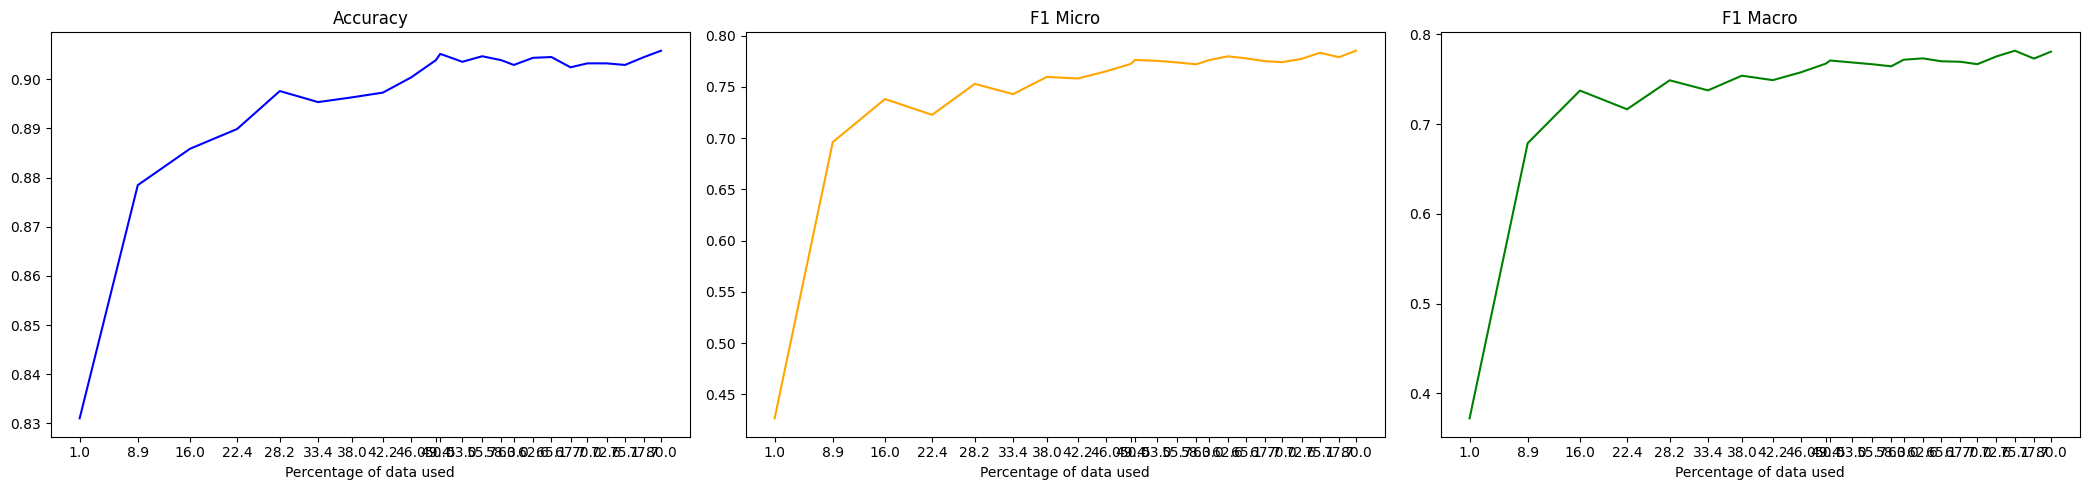

In [20]:
initial_train_size = int(0.01 * total_data)
active_learning(50, 0, 1)

Init Size: 10
Random seed: 50
label num 4
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 4.8816657066345215 | ACCURACY: 0.8191 | F1 MACRO: 0.1935 | F1 MICRO: 0.2652
EPOCH 2 | LOSS: 3.407249689102173 | ACCURACY: 0.8442 | F1 MACRO: 0.4074 | F1 MICRO: 0.4742
EPOCH 3 | LOSS: 3.166126012802124 | ACCURACY: 0.873 | F1 MACRO: 0.6699 | F1 MICRO: 0.6711
EPOCH 4 | LOSS: 3.0293338298797607 | ACCURACY: 0.8675 | F1 MACRO: 0.5896 | F1 MICRO: 0.6241
EPOCH 5 | LOSS: 2.9558322429656982 | ACCURACY: 0.8756 | F1 MACRO: 0.6341 | F1 MICRO: 0.6629
EPOCH 6 | LOSS: 2.8809568881988525 | ACCURACY: 0.876 | F1 MACRO: 0.6612 | F1 MICRO: 0.6781
EPOCH 7 | LOSS: 2.7848641872406006 | ACCURACY: 0.8855 | F1 MACRO: 0.7164 | F1 MICRO: 0.7192
EPOCH 8 | LOSS: 2.7177703380584717 | ACCURACY: 0.8801 | F1 MACRO: 0.6813 | F1 MICRO: 0.692
EPOCH 9 | LOSS: 2.657853841781616 | ACCURACY: 0.8796 | F1 MACRO: 0.6914 | F1 MICRO: 0.6961
EPOCH 10 | LOSS: 2.633970260620117 | ACCURACY: 0.881 | F1 MACRO: 0.7038 | F1 MICRO: 0.7121
Iteration 777: ACCURACY 0.8855 | F1 MACRO 0.7164 | F1 MICRO 0.7192
                    

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 4.1273112297058105 | ACCURACY: 0.8318 | F1 MACRO: 0.3189 | F1 MICRO: 0.3818
EPOCH 2 | LOSS: 3.0621731281280518 | ACCURACY: 0.8698 | F1 MACRO: 0.6502 | F1 MICRO: 0.6541
EPOCH 3 | LOSS: 2.9397494792938232 | ACCURACY: 0.8736 | F1 MACRO: 0.5846 | F1 MICRO: 0.6368
EPOCH 4 | LOSS: 2.7916805744171143 | ACCURACY: 0.8773 | F1 MACRO: 0.6359 | F1 MICRO: 0.6505
EPOCH 5 | LOSS: 2.755244016647339 | ACCURACY: 0.8812 | F1 MACRO: 0.7175 | F1 MICRO: 0.7187
EPOCH 6 | LOSS: 2.6401774883270264 | ACCURACY: 0.8863 | F1 MACRO: 0.712 | F1 MICRO: 0.7218
EPOCH 7 | LOSS: 2.5936391353607178 | ACCURACY: 0.8867 | F1 MACRO: 0.7191 | F1 MICRO: 0.7271
EPOCH 8 | LOSS: 2.5294394493103027 | ACCURACY: 0.8868 | F1 MACRO: 0.7184 | F1 MICRO: 0.7239
EPOCH 9 | LOSS: 2.4417834281921387 | ACCURACY: 0.8876 | F1 MACRO: 0.692 | F1 MICRO: 0.7094
EPOCH 10 | LOSS: 2.432110071182251 | ACCURACY: 0.8916 | F1 MACRO: 0.7078 | F1 MICRO: 0.7192
Iteration 1322: ACCURACY 0.8867 | F1 MACRO 0.7191 | F1 MICRO 0.7271
               

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 3886
Threshold: 2.3341212272644043
Samples above threshold: 490
Acquired samples: 490
Sampling duration: 46.76761054992676 seconds
New train size: 1812
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 3.9198150634765625 | ACCURACY: 0.85 | F1 MACRO: 0.5583 | F1 MICRO: 0.6178
EPOCH 2 | LOSS: 3.0328874588012695 | ACCURACY: 0.8764 | F1 MACRO: 0.6934 | F1 MICRO: 0.6942
EPOCH 3 | LOSS: 2.8939619064331055 | ACCURACY: 0.8834 | F1 MACRO: 0.681 | F1 MICRO: 0.6884
EPOCH 4 | LOSS: 2.8193068504333496 | ACCURACY: 0.8876 | F1 MACRO: 0.6978 | F1 MICRO: 0.7052
EPOCH 5 | LOSS: 2.7271275520324707 | ACCURACY: 0.8915 | F1 MACRO: 0.6979 | F1 MICRO: 0.7134
EPOCH 6 | LOSS: 2.6424496173858643 | ACCURACY: 0.8891 | F1 MACRO: 0.6829 | F1 MICRO: 0.6939
EPOCH 7 | LOSS: 2.581449270248413 | ACCURACY: 0.8934 | F1 MACRO: 0.7172 | F1 MICRO: 0.7273
EPOCH 8 | LOSS: 2.499758720397949 | ACCURACY: 0.8941 | F1 MACRO: 0.7281 | F1 MICRO: 0.7346
EPOCH 9 | LOSS: 2.4134085178375244 | ACCURACY: 0.8915 | F1 MACRO: 0.7252 | F1 MICRO: 0.7333
EPOCH 10 | LOSS: 2.399445056915283 | ACCURACY: 0.895 | F1 MACRO: 0.7225 | F1 MICRO: 0.7325
Iteration 1812: ACCURACY 0.8941 | F1 MACRO 0.7281 | F1 MICRO 0.7346
                  

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 3886
Threshold: 1.8596320152282715
Samples above threshold: 441
Acquired samples: 441
Sampling duration: 46.98404288291931 seconds
New train size: 2253
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 3.710523843765259 | ACCURACY: 0.8601 | F1 MACRO: 0.5751 | F1 MICRO: 0.595
EPOCH 2 | LOSS: 2.9824745655059814 | ACCURACY: 0.8793 | F1 MACRO: 0.6414 | F1 MICRO: 0.6684
EPOCH 3 | LOSS: 2.8286192417144775 | ACCURACY: 0.8953 | F1 MACRO: 0.7294 | F1 MICRO: 0.7422
EPOCH 4 | LOSS: 2.747408866882324 | ACCURACY: 0.8907 | F1 MACRO: 0.7026 | F1 MICRO: 0.7049
EPOCH 5 | LOSS: 2.679196357727051 | ACCURACY: 0.8929 | F1 MACRO: 0.7037 | F1 MICRO: 0.7275
EPOCH 6 | LOSS: 2.5804672241210938 | ACCURACY: 0.8989 | F1 MACRO: 0.7417 | F1 MICRO: 0.754
EPOCH 7 | LOSS: 2.5286543369293213 | ACCURACY: 0.8963 | F1 MACRO: 0.7509 | F1 MICRO: 0.7543
EPOCH 8 | LOSS: 2.428964853286743 | ACCURACY: 0.8941 | F1 MACRO: 0.7265 | F1 MICRO: 0.7373
EPOCH 9 | LOSS: 2.3793559074401855 | ACCURACY: 0.8974 | F1 MACRO: 0.7335 | F1 MICRO: 0.7427
EPOCH 10 | LOSS: 2.3320231437683105 | ACCURACY: 0.8947 | F1 MACRO: 0.7366 | F1 MICRO: 0.7462
Iteration 2253: ACCURACY 0.8963 | F1 MACRO 0.7509 | F1 MICRO 0.7543
                 

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 3.5783259868621826 | ACCURACY: 0.8757 | F1 MACRO: 0.657 | F1 MICRO: 0.6783
EPOCH 2 | LOSS: 2.8967573642730713 | ACCURACY: 0.8876 | F1 MACRO: 0.6876 | F1 MICRO: 0.6978
EPOCH 3 | LOSS: 2.787733793258667 | ACCURACY: 0.8908 | F1 MACRO: 0.6955 | F1 MICRO: 0.7052
EPOCH 4 | LOSS: 2.692314624786377 | ACCURACY: 0.8998 | F1 MACRO: 0.7356 | F1 MICRO: 0.7499
EPOCH 5 | LOSS: 2.610163927078247 | ACCURACY: 0.8966 | F1 MACRO: 0.7221 | F1 MICRO: 0.7315
EPOCH 6 | LOSS: 2.524380683898926 | ACCURACY: 0.8929 | F1 MACRO: 0.6874 | F1 MICRO: 0.7071
EPOCH 7 | LOSS: 2.4589409828186035 | ACCURACY: 0.8971 | F1 MACRO: 0.7443 | F1 MICRO: 0.7554
EPOCH 8 | LOSS: 2.3664920330047607 | ACCURACY: 0.8979 | F1 MACRO: 0.7363 | F1 MICRO: 0.7479
EPOCH 9 | LOSS: 2.3254334926605225 | ACCURACY: 0.8941 | F1 MACRO: 0.7205 | F1 MICRO: 0.73
EPOCH 10 | LOSS: 2.2855939865112305 | ACCURACY: 0.8936 | F1 MACRO: 0.7192 | F1 MICRO: 0.7326
Iteration 2650: ACCURACY 0.8971 | F1 MACRO 0.7443 | F1 MICRO 0.7554
                  

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 3886
Threshold: 1.8048641681671143
Samples above threshold: 357
Acquired samples: 357
Sampling duration: 46.697094440460205 seconds
New train size: 3007
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 3.4823200702667236 | ACCURACY: 0.8699 | F1 MACRO: 0.6028 | F1 MICRO: 0.6517
EPOCH 2 | LOSS: 2.845923900604248 | ACCURACY: 0.882 | F1 MACRO: 0.6596 | F1 MICRO: 0.6741
EPOCH 3 | LOSS: 2.7196457386016846 | ACCURACY: 0.8977 | F1 MACRO: 0.7365 | F1 MICRO: 0.7478
EPOCH 4 | LOSS: 2.6416239738464355 | ACCURACY: 0.8916 | F1 MACRO: 0.6981 | F1 MICRO: 0.7059
EPOCH 5 | LOSS: 2.5646862983703613 | ACCURACY: 0.8932 | F1 MACRO: 0.6919 | F1 MICRO: 0.7123
EPOCH 6 | LOSS: 2.46756649017334 | ACCURACY: 0.8953 | F1 MACRO: 0.7077 | F1 MICRO: 0.7207
EPOCH 7 | LOSS: 2.4072377681732178 | ACCURACY: 0.9034 | F1 MACRO: 0.7452 | F1 MICRO: 0.7522
EPOCH 8 | LOSS: 2.3512370586395264 | ACCURACY: 0.8986 | F1 MACRO: 0.7437 | F1 MICRO: 0.7526
EPOCH 9 | LOSS: 2.284464120864868 | ACCURACY: 0.8997 | F1 MACRO: 0.7393 | F1 MICRO: 0.7502
EPOCH 10 | LOSS: 2.2347402572631836 | ACCURACY: 0.8984 | F1 MACRO: 0.735 | F1 MICRO: 0.7445
Iteration 3007: ACCURACY 0.8986 | F1 MACRO 0.7437 | F1 MICRO 0.7526
                 

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 3886
Threshold: 1.5130568742752075
Samples above threshold: 322
Acquired samples: 322
Sampling duration: 46.82650017738342 seconds
New train size: 3329
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
EPOCH 1 | LOSS: 3.4511165618896484 | ACCURACY: 0.8706 | F1 MACRO: 0.5808 | F1 MICRO: 0.6222
EPOCH 2 | LOSS: 2.8215861320495605 | ACCURACY: 0.8894 | F1 MACRO: 0.6729 | F1 MICRO: 0.6929
EPOCH 3 | LOSS: 2.7092907428741455 | ACCURACY: 0.8929 | F1 MACRO: 0.7161 | F1 MICRO: 0.7232
EPOCH 4 | LOSS: 2.5989789962768555 | ACCURACY: 0.8969 | F1 MACRO: 0.7177 | F1 MICRO: 0.7224
EPOCH 5 | LOSS: 2.5435523986816406 | ACCURACY: 0.8939 | F1 MACRO: 0.7051 | F1 MICRO: 0.7163
EPOCH 6 | LOSS: 2.4446139335632324 | ACCURACY: 0.9021 | F1 MACRO: 0.7546 | F1 MICRO: 0.7594
EPOCH 7 | LOSS: 2.3694117069244385 | ACCURACY: 0.8984 | F1 MACRO: 0.7347 | F1 MICRO: 0.7445
EPOCH 8 | LOSS: 2.3154828548431396 | ACCURACY: 0.9024 | F1 MACRO: 0.7619 | F1 MICRO: 0.767
EPOCH 9 | LOSS: 2.2621877193450928 | 

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 3886
Threshold: 1.490330743789673
Samples above threshold: 289
Acquired samples: 289
Sampling duration: 46.47620964050293 seconds
New train size: 3618
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 3.4216058254241943 | ACCURACY: 0.8741 | F1 MACRO: 0.6074 | F1 MICRO: 0.6397
EPOCH 2 | LOSS: 2.760763645172119 | ACCURACY: 0.8846 | F1 MACRO: 0.6381 | F1 MICRO: 0.6664
EPOCH 3 | LOSS: 2.658079147338867 | ACCURACY: 0.895 | F1 MACRO: 0.6983 | F1 MICRO: 0.7196
EPOCH 4 | LOSS: 2.5759923458099365 | ACCURACY: 0.9032 | F1 MACRO: 0.7425 | F1 MICRO: 0.749
EPOCH 5 | LOSS: 2.527535915374756 | ACCURACY: 0.9066 | F1 MACRO: 0.7507 | F1 MICRO: 0.7651
EPOCH 6 | LOSS: 2.4459550380706787 | ACCURACY: 0.9005 | F1 MACRO: 0.7365 | F1 MICRO: 0.7487
EPOCH 7 | LOSS: 2.351823091506958 | ACCURACY: 0.9021 | F1 MACRO: 0.7483 | F1 MICRO: 0.7529
EPOCH 8 | LOSS: 2.281550884246826 | ACCURACY: 0.9013 | F1 MACRO: 0.7518 | F1 MICRO: 0.7616
EPOCH 9 | LOSS: 2.227978229522705 | ACCURACY: 0.8995 | F1 MACRO: 0.7432 | F1 MICRO: 0.7477
EPOCH 10 | LOSS: 2.2038323879241943 | ACCURACY: 0.9002 | F1 MACRO: 0.7438 | F1 MICRO: 0.7519
Iteration 3618: ACCURACY 0.9066 | F1 MACRO 0.7507 | F1 MICRO 0.7651
                   

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 4663
Threshold: 1.4325130820274354
Samples above threshold: 234
Acquired samples: 234
Sampling duration: 45.549628019332886 seconds
New train size: 4120
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 3.3472824096679688 | ACCURACY: 0.8844 | F1 MACRO: 0.6909 | F1 MICRO: 0.7035
EPOCH 2 | LOSS: 2.751861572265625 | ACCURACY: 0.8977 | F1 MACRO: 0.7308 | F1 MICRO: 0.746
EPOCH 3 | LOSS: 2.6472158432006836 | ACCURACY: 0.9032 | F1 MACRO: 0.7542 | F1 MICRO: 0.7615
EPOCH 4 | LOSS: 2.5593433380126953 | ACCURACY: 0.9005 | F1 MACRO: 0.7509 | F1 MICRO: 0.7547
EPOCH 5 | LOSS: 2.462454080581665 | ACCURACY: 0.9026 | F1 MACRO: 0.762 | F1 MICRO: 0.7678
EPOCH 6 | LOSS: 2.4104418754577637 | ACCURACY: 0.9029 | F1 MACRO: 0.76 | F1 MICRO: 0.7668
EPOCH 7 | LOSS: 2.3403167724609375 | ACCURACY: 0.904 | F1 MACRO: 0.753 | F1 MICRO: 0.7596
EPOCH 8 | LOSS: 2.2876644134521484 | ACCURACY: 0.9029 | F1 MACRO: 0.7684 | F1 MICRO: 0.7703
EPOCH 9 | LOSS: 2.251396656036377 | ACCURACY: 0.9023 | F1 MACRO: 0.754 | F1 MICRO: 0.758
EPOCH 10 | LOSS: 2.2139523029327393 | ACCURACY: 0.9013 | F1 MACRO: 0.7582 | F1 MICRO: 0.764
Iteration 4120: ACCURACY 0.9029 | F1 MACRO 0.7684 | F1 MICRO 0.7703
                      p

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 4663
Threshold: 1.0875508785247803
Samples above threshold: 210
Acquired samples: 210
Sampling duration: 45.48437452316284 seconds
New train size: 4330
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
EPOCH 1 | LOSS: 3.3009862899780273 | ACCURACY: 0.8841 | F1 MACRO: 0.6568 | F1 MICRO: 0.7032
EPOCH 2 | LOSS: 2.7390971183776855 | ACCURACY: 0.8953 | F1 MACRO: 0.7145 | F1 MICRO: 0.7264
EPOCH 3 | LOSS: 2.616232395172119 | ACCURACY: 0.9014 | F1 MACRO: 0.725 | F1 MICRO: 0.7455
EPOCH 4 | LOSS: 2.5534636974334717 | ACCURACY: 0.8994 | F1 MACRO: 0.7174 | F1 MICRO: 0.7254
EPOCH 5 | LOSS: 2.467905044555664 | ACCURACY: 0.9019 | F1 MACRO: 0.7328 | F1 MICRO: 0.7437
EPOCH 6 | LOSS: 2.408848762512207 | ACCURACY: 0.9018 | F1 MACRO: 0.7431 | F1 MICRO: 0.7555
EPOCH 7 | LOSS: 2.3337748050689697 | ACCURACY: 0.8995 | F1 MACRO: 0.7558 | F1 MICRO: 0.7595
EPOCH 8 | LOSS: 2.294464588165283 | ACCURACY: 0.8977 | F1 MACRO: 0.7302 | F1 MICRO: 0.7415
EPOCH 9 | LOSS: 2.2185792922973633 | ACCU

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 4663
Threshold: 1.0718958377838135
Samples above threshold: 189
Acquired samples: 200
Sampling duration: 45.54717969894409 seconds
New train size: 4530
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
EPOCH 1 | LOSS: 3.3051843643188477 | ACCURACY: 0.8852 | F1 MACRO: 0.6759 | F1 MICRO: 0.7086
EPOCH 2 | LOSS: 2.72202205657959 | ACCURACY: 0.8977 | F1 MACRO: 0.7127 | F1 MICRO: 0.735
EPOCH 3 | LOSS: 2.616577625274658 | ACCURACY: 0.901 | F1 MACRO: 0.7374 | F1 MICRO: 0.7512
EPOCH 4 | LOSS: 2.543159008026123 | ACCURACY: 0.8995 | F1 MACRO: 0.7195 | F1 MICRO: 0.7312
EPOCH 5 | LOSS: 2.4589250087738037 | ACCURACY: 0.9013 | F1 MACRO: 0.7353 | F1 MICRO: 0.7448
EPOCH 6 | LOSS: 2.412848949432373 | ACCURACY: 0.9016 | F1 MACRO: 0.7475 | F1 MICRO: 0.756
EPOCH 7 | LOSS: 2.3258941173553467 | ACCURACY: 0.9014 | F1 MACRO: 0.7637 | F1 MICRO: 0.7693
EPOCH 8 | LOSS: 2.265782594680786 | ACCURACY: 0.9029 | F1 MACRO: 0.7588 | F1 MICRO: 0.7622
EPOCH 9 | LOSS: 2.23201847076416 | ACCURACY: 

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 4663
Threshold: 1.0533244609832764
Samples above threshold: 169
Acquired samples: 133
Sampling duration: 45.748897075653076 seconds
New train size: 4663
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
EPOCH 1 | LOSS: 3.299245595932007 | ACCURACY: 0.8817 | F1 MACRO: 0.6443 | F1 MICRO: 0.67
EPOCH 2 | LOSS: 2.715104579925537 | ACCURACY: 0.8968 | F1 MACRO: 0.7237 | F1 MICRO: 0.7362
EPOCH 3 | LOSS: 2.606334686279297 | ACCURACY: 0.9035 | F1 MACRO: 0.7597 | F1 MICRO: 0.766
EPOCH 4 | LOSS: 2.527761459350586 | ACCURACY: 0.9053 | F1 MACRO: 0.763 | F1 MICRO: 0.7758
EPOCH 5 | LOSS: 2.4745726585388184 | ACCURACY: 0.9029 | F1 MACRO: 0.7558 | F1 MICRO: 0.7657
EPOCH 6 | LOSS: 2.397022247314453 | ACCURACY: 0.9058 | F1 MACRO: 0.7668 | F1 MICRO: 0.7741
EPOCH 7 | LOSS: 2.3382015228271484 | ACCURACY: 0.9037 | F1 MACRO: 0.7696 | F1 MICRO: 0.7734
EPOCH 8 | LOSS: 2.2703981399536133 | ACCURACY: 0.9047 | F1 MACRO: 0.7776 | F1 MICRO: 0.7791
EPOCH 9 | LOSS: 2.2373766899108887 | ACCURAC

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 5441
Threshold: 1.0408759117126465
Samples above threshold: 156
Acquired samples: 200
Sampling duration: 45.46193981170654 seconds
New train size: 4863
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
EPOCH 1 | LOSS: 3.281949996948242 | ACCURACY: 0.8873 | F1 MACRO: 0.6873 | F1 MICRO: 0.7018
EPOCH 2 | LOSS: 2.7186505794525146 | ACCURACY: 0.8955 | F1 MACRO: 0.7014 | F1 MICRO: 0.7208
EPOCH 3 | LOSS: 2.616804599761963 | ACCURACY: 0.9045 | F1 MACRO: 0.7623 | F1 MICRO: 0.7705
EPOCH 4 | LOSS: 2.544969081878662 | ACCURACY: 0.8955 | F1 MACRO: 0.7076 | F1 MICRO: 0.7152
EPOCH 5 | LOSS: 2.4676263332366943 | ACCURACY: 0.9019 | F1 MACRO: 0.7543 | F1 MICRO: 0.7621
EPOCH 6 | LOSS: 2.4142730236053467 | ACCURACY: 0.9059 | F1 MACRO: 0.7666 | F1 MICRO: 0.7751
EPOCH 7 | LOSS: 2.342360734939575 | ACCURACY: 0.904 | F1 MACRO: 0.7692 | F1 MICRO: 0.7703
EPOCH 8 | LOSS: 2.2887747287750244 | ACCURACY: 0.901 | F1 MACRO: 0.7555 | F1 MICRO: 0.764
EPOCH 9 | LOSS: 2.2407898902893066 | ACCURA

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 3.288952112197876 | ACCURACY: 0.8849 | F1 MACRO: 0.6877 | F1 MICRO: 0.7129
EPOCH 2 | LOSS: 2.721947193145752 | ACCURACY: 0.8973 | F1 MACRO: 0.7253 | F1 MICRO: 0.7339
EPOCH 3 | LOSS: 2.6118669509887695 | ACCURACY: 0.9 | F1 MACRO: 0.7327 | F1 MICRO: 0.7417
EPOCH 4 | LOSS: 2.5454671382904053 | ACCURACY: 0.9 | F1 MACRO: 0.726 | F1 MICRO: 0.74
EPOCH 5 | LOSS: 2.483531951904297 | ACCURACY: 0.896 | F1 MACRO: 0.6963 | F1 MICRO: 0.7222
EPOCH 6 | LOSS: 2.406313896179199 | ACCURACY: 0.9016 | F1 MACRO: 0.7325 | F1 MICRO: 0.7471
EPOCH 7 | LOSS: 2.342019557952881 | ACCURACY: 0.9063 | F1 MACRO: 0.7673 | F1 MICRO: 0.7727
EPOCH 8 | LOSS: 2.2960708141326904 | ACCURACY: 0.9 | F1 MACRO: 0.7632 | F1 MICRO: 0.7684
EPOCH 9 | LOSS: 2.250742197036743 | ACCURACY: 0.9035 | F1 MACRO: 0.7667 | F1 MICRO: 0.7738
EPOCH 10 | LOSS: 2.220874071121216 | ACCURACY: 0.9034 | F1 MACRO: 0.76 | F1 MICRO: 0.7688
Iteration 5063: ACCURACY 0.9035 | F1 MACRO 0.7667 | F1 MICRO 0.7738
                      precision  

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 5441
Threshold: 1.00698721408844
Samples above threshold: 116
Acquired samples: 200
Sampling duration: 45.35433864593506 seconds
New train size: 5263
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 3.2740421295166016 | ACCURACY: 0.8863 | F1 MACRO: 0.6431 | F1 MICRO: 0.697
EPOCH 2 | LOSS: 2.720970869064331 | ACCURACY: 0.899 | F1 MACRO: 0.7342 | F1 MICRO: 0.7466
EPOCH 3 | LOSS: 2.620819091796875 | ACCURACY: 0.8942 | F1 MACRO: 0.6791 | F1 MICRO: 0.7068
EPOCH 4 | LOSS: 2.543781280517578 | ACCURACY: 0.9027 | F1 MACRO: 0.7364 | F1 MICRO: 0.753
EPOCH 5 | LOSS: 2.4723117351531982 | ACCURACY: 0.9013 | F1 MACRO: 0.7502 | F1 MICRO: 0.756
EPOCH 6 | LOSS: 2.400531768798828 | ACCURACY: 0.9003 | F1 MACRO: 0.7748 | F1 MICRO: 0.7758
EPOCH 7 | LOSS: 2.3475069999694824 | ACCURACY: 0.9039 | F1 MACRO: 0.7627 | F1 MICRO: 0.7693
EPOCH 8 | LOSS: 2.306724786758423 | ACCURACY: 0.9037 | F1 MACRO: 0.7486 | F1 MICRO: 0.7605
EPOCH 9 | LOSS: 2.2570884227752686 | ACCURACY: 0.9039 | F1 MACRO: 0.7611 | F1 MICRO: 0.768
EPOCH 10 | LOSS: 2.227069854736328 | ACCURACY: 0.9042 | F1 MACRO: 0.7693 | F1 MICRO: 0.7706
Iteration 5263: ACCURACY 0.9003 | F1 MACRO 0.7748 | F1 MICRO 0.7758
                      

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 5441
Threshold: 1.0072886943817139
Samples above threshold: 96
Acquired samples: 178
Sampling duration: 45.64526605606079 seconds
New train size: 5441
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
EPOCH 1 | LOSS: 3.255674123764038 | ACCURACY: 0.8857 | F1 MACRO: 0.6791 | F1 MICRO: 0.6999
EPOCH 2 | LOSS: 2.7148828506469727 | ACCURACY: 0.9011 | F1 MACRO: 0.7357 | F1 MICRO: 0.7458
EPOCH 3 | LOSS: 2.6262927055358887 | ACCURACY: 0.8949 | F1 MACRO: 0.6989 | F1 MICRO: 0.7169
EPOCH 4 | LOSS: 2.5613372325897217 | ACCURACY: 0.9053 | F1 MACRO: 0.7588 | F1 MICRO: 0.7645
EPOCH 5 | LOSS: 2.4961488246917725 | ACCURACY: 0.9058 | F1 MACRO: 0.7616 | F1 MICRO: 0.7706
EPOCH 6 | LOSS: 2.4288532733917236 | ACCURACY: 0.904 | F1 MACRO: 0.7398 | F1 MICRO: 0.7528
EPOCH 7 | LOSS: 2.3614940643310547 | ACCURACY: 0.9035 | F1 MACRO: 0.7618 | F1 MICRO: 0.768
EPOCH 8 | LOSS: 2.306576728820801 | ACCURACY: 0.9027 | F1 MACRO: 0.7552 | F1 MICRO: 0.7612
EPOCH 9 | LOSS: 2.269925594329834 | ACCUR

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 3.2293996810913086 | ACCURACY: 0.886 | F1 MACRO: 0.6742 | F1 MICRO: 0.6916
EPOCH 2 | LOSS: 2.7148306369781494 | ACCURACY: 0.8981 | F1 MACRO: 0.7198 | F1 MICRO: 0.7304
EPOCH 3 | LOSS: 2.618346929550171 | ACCURACY: 0.9016 | F1 MACRO: 0.7602 | F1 MICRO: 0.7677
EPOCH 4 | LOSS: 2.54361629486084 | ACCURACY: 0.9056 | F1 MACRO: 0.7711 | F1 MICRO: 0.7777
EPOCH 5 | LOSS: 2.478811502456665 | ACCURACY: 0.9063 | F1 MACRO: 0.7843 | F1 MICRO: 0.7885
EPOCH 6 | LOSS: 2.413576126098633 | ACCURACY: 0.9076 | F1 MACRO: 0.7882 | F1 MICRO: 0.7902
EPOCH 7 | LOSS: 2.3503003120422363 | ACCURACY: 0.9056 | F1 MACRO: 0.7721 | F1 MICRO: 0.7801
EPOCH 8 | LOSS: 2.3049426078796387 | ACCURACY: 0.9042 | F1 MACRO: 0.7605 | F1 MICRO: 0.7699
EPOCH 9 | LOSS: 2.254373788833618 | ACCURACY: 0.9018 | F1 MACRO: 0.767 | F1 MICRO: 0.7707
EPOCH 10 | LOSS: 2.227871894836426 | ACCURACY: 0.8994 | F1 MACRO: 0.7602 | F1 MICRO: 0.7662
Iteration 5641: ACCURACY 0.9076 | F1 MACRO 0.7882 | F1 MICRO 0.7902
                    

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 3.2517409324645996 | ACCURACY: 0.8868 | F1 MACRO: 0.6553 | F1 MICRO: 0.6936
EPOCH 2 | LOSS: 2.716168165206909 | ACCURACY: 0.8973 | F1 MACRO: 0.7163 | F1 MICRO: 0.7356
EPOCH 3 | LOSS: 2.609266757965088 | ACCURACY: 0.9039 | F1 MACRO: 0.7333 | F1 MICRO: 0.7549
EPOCH 4 | LOSS: 2.5463204383850098 | ACCURACY: 0.9071 | F1 MACRO: 0.7544 | F1 MICRO: 0.7623
EPOCH 5 | LOSS: 2.4746246337890625 | ACCURACY: 0.909 | F1 MACRO: 0.771 | F1 MICRO: 0.7763
EPOCH 6 | LOSS: 2.4083809852600098 | ACCURACY: 0.9055 | F1 MACRO: 0.7747 | F1 MICRO: 0.7776
EPOCH 7 | LOSS: 2.3645219802856445 | ACCURACY: 0.9043 | F1 MACRO: 0.7641 | F1 MICRO: 0.7662
EPOCH 8 | LOSS: 2.306671142578125 | ACCURACY: 0.9048 | F1 MACRO: 0.7621 | F1 MICRO: 0.7673
EPOCH 9 | LOSS: 2.262096881866455 | ACCURACY: 0.9 | F1 MACRO: 0.7538 | F1 MICRO: 0.7602
EPOCH 10 | LOSS: 2.2389681339263916 | ACCURACY: 0.9034 | F1 MACRO: 0.7707 | F1 MICRO: 0.7738
Iteration 5841: ACCURACY 0.9055 | F1 MACRO 0.7747 | F1 MICRO 0.7776
                    

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 6218
Threshold: 0.9538216590881348
Samples above threshold: 38
Acquired samples: 200
Sampling duration: 45.8013060092926 seconds
New train size: 6041
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 3.2247745990753174 | ACCURACY: 0.8929 | F1 MACRO: 0.7364 | F1 MICRO: 0.7456
EPOCH 2 | LOSS: 2.7034215927124023 | ACCURACY: 0.9002 | F1 MACRO: 0.7563 | F1 MICRO: 0.7616
EPOCH 3 | LOSS: 2.60089373588562 | ACCURACY: 0.9058 | F1 MACRO: 0.7632 | F1 MICRO: 0.773
EPOCH 4 | LOSS: 2.540879487991333 | ACCURACY: 0.8995 | F1 MACRO: 0.7293 | F1 MICRO: 0.7368
EPOCH 5 | LOSS: 2.4844682216644287 | ACCURACY: 0.9063 | F1 MACRO: 0.7605 | F1 MICRO: 0.7689
EPOCH 6 | LOSS: 2.4126198291778564 | ACCURACY: 0.8986 | F1 MACRO: 0.7437 | F1 MICRO: 0.7576
EPOCH 7 | LOSS: 2.363779067993164 | ACCURACY: 0.9016 | F1 MACRO: 0.7568 | F1 MICRO: 0.7587
EPOCH 8 | LOSS: 2.312919855117798 | ACCURACY: 0.8998 | F1 MACRO: 0.7567 | F1 MICRO: 0.7668
EPOCH 9 | LOSS: 2.2639975547790527 | ACCURACY: 0.8998 | F1 MACRO: 0.7607 | F1 MICRO: 0.7666
EPOCH 10 | LOSS: 2.2324867248535156 | ACCURACY: 0.9008 | F1 MACRO: 0.7526 | F1 MICRO: 0.7604
Iteration 6041: ACCURACY 0.9058 | F1 MACRO 0.7632 | F1 MICRO 0.773
                  

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 6218
Threshold: 1.4551167488098145
Samples above threshold: 18
Acquired samples: 177
Sampling duration: 45.075867891311646 seconds
New train size: 6218
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
EPOCH 1 | LOSS: 3.216951370239258 | ACCURACY: 0.8879 | F1 MACRO: 0.683 | F1 MICRO: 0.7033
EPOCH 2 | LOSS: 2.6977038383483887 | ACCURACY: 0.9026 | F1 MACRO: 0.7512 | F1 MICRO: 0.768
EPOCH 3 | LOSS: 2.6078009605407715 | ACCURACY: 0.8992 | F1 MACRO: 0.7112 | F1 MICRO: 0.7287
EPOCH 4 | LOSS: 2.5390541553497314 | ACCURACY: 0.904 | F1 MACRO: 0.7567 | F1 MICRO: 0.7613
EPOCH 5 | LOSS: 2.470536470413208 | ACCURACY: 0.9031 | F1 MACRO: 0.7428 | F1 MICRO: 0.7526
EPOCH 6 | LOSS: 2.4129762649536133 | ACCURACY: 0.9058 | F1 MACRO: 0.7808 | F1 MICRO: 0.7853
EPOCH 7 | LOSS: 2.3449201583862305 | ACCURACY: 0.905 | F1 MACRO: 0.7612 | F1 MICRO: 0.7674
EPOCH 8 | LOSS: 2.2943811416625977 | ACCURACY: 0.9037 | F1 MACRO: 0.7762 | F1 MICRO: 0.7811
EPOCH 9 | LOSS: 2.257314682006836 | ACCURA

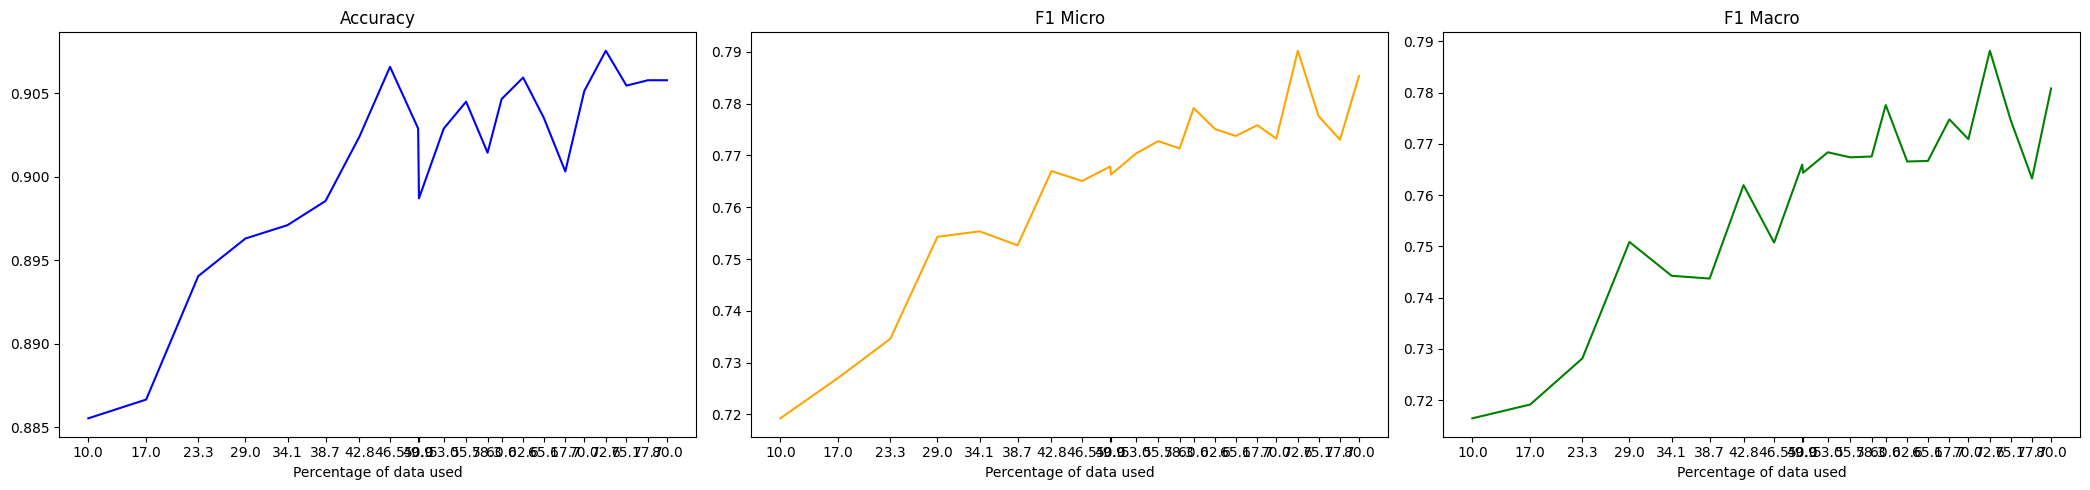

In [21]:
initial_train_size = int(0.1 * total_data)
active_learning(50, 0, 10)